# Recursive Density Estimation

Graphs look maybe little bit different because of randomness


## 1. Kalman Filter




In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
np.random.seed(123)

## 1.1 Kalman Filter Implementation

In [3]:
# KalmanFilter class definition
class KalmanFilter:
    def __init__(self, dt, initial_state, initial_covariance, transition_covariance, observation_covariance):
        self.dt = dt
        self.state = initial_state
        self.covariance = initial_covariance
        self.transition_covariance = transition_covariance
        self.observation_covariance = observation_covariance

        self.observation_matrix = np.array([[1, 0, 0, 0],
                                            [0, 1, 0, 0]])

    def predict(self, control_input=None):
        # Prediction step

        # State transition matrix
        A = np.array([[1, 0, self.dt, 0],
                      [0, 1, 0, self.dt],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

        # Control input matrix
        B = np.array([[0, 0, 0],
                      [0, 0.5 * self.dt ** 2, 0],
                      [0, 0, 0],
                      [0, self.dt, 0]])

        # Control input (acceleration)
        a = np.array([[0], [-9.8], [0]])

        # State prediction
        self.state = np.dot(A, self.state) + np.dot(B, a)

        # Covariance prediction
        self.covariance = np.dot(np.dot(A, self.covariance), A.T) + self.transition_covariance

    def update(self, measurement):
        # Update step

        # Observation matrix
        H = self.observation_matrix

        # Measurement residual
        y = measurement - np.dot(H, self.state)

        # Innovation covariance
        S = np.dot(np.dot(H, self.covariance), H.T) + self.observation_covariance
        # Kalman gain
        K = np.dot(np.dot(self.covariance, H.T), np.linalg.inv(S))

        # State update
        self.state = self.state + np.dot(K, y)

        I = np.eye(self.state.shape[0])  # Identity matrix

        # Covariance update
        self.covariance = np.dot((I - np.dot(K, H)), self.covariance)

    def get_state(self):
        return self.state

## 1.2 Tracjectory of kalman filter 

In [4]:
def simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=10.0, dt=0.1,
                             observation_time_step=0.5, observation_error_std=0.5, R_val=1, Q_val=1, 
                             skip_ob_start_time = 1.0, skip_ob_stop_time = 3.0, skip_observations = False):
    # Convert launch angle from degrees to radians
    launch_angle_rad = np.radians(launch_angle)

    # Calculate initial state based on launch position, launch speed, and launch angle
    initial_state = np.array([[launch_position[0]], [launch_position[1]],
                              [launch_speed * np.cos(launch_angle_rad)], [launch_speed * np.sin(launch_angle_rad)]])

    # Initialize the Kalman filter
    filter = KalmanFilter(dt, initial_state, np.eye(4), np.array([[R_val, 0, 0, 0], [0, R_val, 0, 0],
                                                                  [0, 0, R_val, 0], [0, 0, 0, R_val]]),
                          np.array([[Q_val, 0], [0, Q_val]]))

    time = np.arange(0, total_time, dt)
    observations = []
    actual_velocities = []
    predicted_velocities = []
    predicted_observations = []
    true_positions = []  # List to store true positions

    for t in time:
            
        # Simulate ball trajectory (example: simple parabolic motion in x and y directions)
        position_x = initial_state[0, 0] + initial_state[2, 0] * dt
        position_y = initial_state[1, 0] + initial_state[3, 0] * dt + 0.5 * (-9.8) * dt ** 2
        velocity_x = initial_state[2, 0]
        velocity_y = initial_state[3, 0] + (-9.8) * dt
        
        # Simulate observation (with noise)
        if skip_observations and skip_ob_start_time <= t <= skip_ob_stop_time:
            observation = np.array([[observations[-1][0]], [observations[-1][1]]])
        else:
            observation = np.array([[position_x + np.random.normal(0, observation_error_std)],
                                    [position_y + np.random.normal(0, observation_error_std)]])

        
        # Update filter with observation
        filter.predict()
        filter.update(observation)

        # Store estimated state
        estimated_state = filter.get_state()
        
        # Store true position
        true_positions.append([position_x, position_y])

        # Print actual observation, predicted observation, actual velocity (X and Y), and predicted velocity (X and Y)
        print(f"Time: {t:.2f}")
        print(f"Actual Observation: {observation.flatten()}")
        print(f"Predicted Observation: {np.dot(filter.observation_matrix, estimated_state).flatten()}")
        print(f"Actual Velocity (X, Y): ({velocity_x:.2f}, {velocity_y:.2f})")
        print(f"Predicted Velocity (X, Y): ({estimated_state[2, 0]:.2f}, {estimated_state[3, 0]:.2f})")
        print()

        # Adjust initial state for the next iteration
        initial_state = estimated_state
        observations.append(observation.flatten())
        actual_velocities.append([velocity_x, velocity_y])
        predicted_velocities.append([estimated_state[2, 0], estimated_state[3, 0]])
        predicted_observations.append(np.dot(filter.observation_matrix, estimated_state).flatten()[1])

        # Adjust initial state for the next iteration
        initial_state = estimated_state

    # Convert observations, actual velocities, predicted velocities, predicted observations, and true positions to numpy arrays
    observations = np.array(observations)
    actual_velocities = np.array(actual_velocities)
    predicted_velocities = np.array(predicted_velocities)
    predicted_observations = np.array(predicted_observations)
    true_positions = np.array(true_positions)

#     # Plot observations, velocities, and true trajectory
#     plt.figure(figsize=(12, 8))

#     plt.plot(time, observations[:, 1], 'bo', label='Actual Y Observation')
#     plt.plot(time, predicted_observations, 'g', label='Predicted Y Observation')
#     plt.plot(time, actual_velocities[:, 0], 'b--', label='Actual X Velocity')
#     plt.plot(time, actual_velocities[:, 1], 'r--', label='Actual Y Velocity')
#     plt.plot(time, predicted_velocities[:, 0], 'y', label='Predicted X Velocity')
#     plt.plot(time, predicted_velocities[:, 1], 'g', label='Predicted Y Velocity')
#     plt.plot(time, true_positions[:, 1], 'k', label='True Y Position')  # Plotting true Y positions

#     plt.xlabel('Time')
#     plt.ylabel('Observation / Velocity / Position')
#     plt.legend()

    
     # Plot observations, velocities, and true trajectory
    plt.figure(figsize=(10, 6))

    plt.plot(time, observations[:, 1], 'bo', label='Actual Y Observation', markersize=5)
    plt.plot(time, predicted_observations, 'k--', label='Predicted Y Observation')
    plt.plot(time, actual_velocities[:, 0], 'C2--', label='Actual X Velocity')
    plt.plot(time, actual_velocities[:, 1], 'C1--', label='Actual Y Velocity')
    plt.plot(time, predicted_velocities[:, 0], 'C2', label='Predicted X Velocity')
    plt.plot(time, predicted_velocities[:, 1], 'C1', label='Predicted Y Velocity')
    plt.plot(time, true_positions[:, 1], 'r', label='True Y Position', linewidth=2)

    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Observation / Velocity / Position', fontsize=12)
    plt.title('Ball Trajectory Simulation', fontsize=14)
    plt.legend(fontsize=10)

    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
    return observations, predicted_observations
    

In [5]:
def calculate_accuracy(actual_values, predicted_values):
    rmse = np.sqrt(np.mean((actual_values[:, 1] - predicted_values) ** 2))
    mae = np.mean(np.abs(actual_values[:, 1] - predicted_values))
    return rmse, mae

# 2. Particle Filter

## 2.1. Particle Filter Implementation

In [6]:
class CondensationFilter:
    def __init__(self, dt, num_particles, initial_state, initial_covariance, transition_covariance, observation_covariance):
        self.dt = dt
        self.num_particles = num_particles
#         self.particles = [initial_state + np.random.multivariate_normal(np.zeros(initial_state.shape), initial_covariance).reshape(-1, 1) for _ in range(num_particles)]
        self.particles = [initial_state + np.random.multivariate_normal(np.zeros(initial_state.shape[0]), initial_covariance).reshape((-1, 1)) for _ in range(num_particles)]

        self.weights = np.ones(num_particles) / num_particles
        self.transition_covariance = transition_covariance
        self.observation_covariance = observation_covariance

        self.observation_matrix = np.array([[1, 0, 0, 0],
                                            [0, 1, 0, 0]])

    def predict(self, control_input=None):
        # Prediction step

        # State transition matrix
        A = np.array([[1, 0, self.dt, 0],
                      [0, 1, 0, self.dt],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])

        # Control input matrix
        B = np.array([[0, 0, 0],
                      [0, 0.5 * self.dt ** 2, 0],
                      [0, 0, 0],
                      [0, self.dt, 0]])

        # Control input (acceleration)
        a = np.array([[0], [-9.8], [0]])

        # State prediction
        self.particles = [np.dot(A, particle) + np.dot(B, a) + np.random.multivariate_normal(np.zeros(particle.shape[0]), self.transition_covariance) for particle in self.particles]

    def update(self, measurement):
        # Update step

        # Observation matrix
        H = self.observation_matrix

        for i, particle in enumerate(self.particles):
            # Measurement residual
            y = measurement - np.dot(H, particle)

            # Particle weight update
            self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]

        
        # Normalize weights and handle NaN values
        self.weights /= np.sum(self.weights)
        self.weights[np.isnan(self.weights)] = np.finfo(float).eps
        self.weights /= np.sum(self.weights)

        # Resampling
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=self.weights)
        self.particles = [self.particles[index] for index in indices]
        self.weights = np.ones(self.num_particles) / self.num_particles


    def get_state(self):
        return np.mean(np.concatenate(self.particles, axis=1), axis=1).reshape((-1, 1))




## 2.2. Tracjectory of Particle filter (1 Ball)

In [7]:
def simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle, no_particles=100, total_time=10.0, dt=0.1,
                             observation_time_step=0.5, observation_error_std=0.5, R_val=1, Q_val=1,
                             skip_ob_start_time=1.0, skip_ob_stop_time=3.0, skip_observations=False):
    # Convert launch angle from degrees to radians
    launch_angle_rad = np.radians(launch_angle)

    # Calculate initial state based on launch position, launch speed, and launch angle
    initial_state = np.array([[launch_position[0]], [launch_position[1]],
                              [launch_speed * np.cos(launch_angle_rad)], [launch_speed * np.sin(launch_angle_rad)]])

    # Initialize the Condensation Filter
    filter = CondensationFilter(dt, num_particles=no_particles, initial_state=initial_state, initial_covariance=np.eye(4),
                                transition_covariance=np.array([[R_val, 0, 0, 0], [0, R_val, 0, 0],
                                                               [0, 0, R_val, 0], [0, 0, 0, R_val]]),
                                observation_covariance=np.array([[Q_val, 0], [0, Q_val]]))

    time = np.arange(0, total_time, dt)
    observations = []
    actual_velocities = []
    predicted_velocities = []
    predicted_observations = []
    true_positions = []  # List to store true positions

    # Initialize a list to store particle trajectories
    particle_trajectories = [[] for _ in range(filter.num_particles)]
    particle_weights = [[] for _ in range(filter.num_particles)]

    for t in time:
#         # Check if skipping new observations is required
#         if t >= skip_ob_start_time and t <= skip_ob_stop_time:
#             skip_observations = True
#         else:
#             skip_observations = False

        # Simulate ball trajectory (example: simple parabolic motion in x and y directions)
        position_x = initial_state[0, 0] + initial_state[2, 0] * dt
        position_y = initial_state[1, 0] + initial_state[3, 0] * dt + 0.5 * (-9.8) * dt ** 2
        velocity_x = initial_state[2, 0]
        velocity_y = initial_state[3, 0] + (-9.8) * dt

        # Simulate observation (with noise)
        if skip_observations and skip_ob_start_time <= t <= skip_ob_stop_time:
            observation = np.array([[observations[-1][0]], [observations[-1][1]]])
        else:
            observation = np.array([[position_x + np.random.normal(0, observation_error_std)],
                                    [position_y + np.random.normal(0, observation_error_std)]])

        # Update filter with observation
        filter.predict()
        filter.update(observation)

        # Store estimated state
        estimated_state = filter.get_state()

        # Store true position
        true_positions.append([position_x, position_y])

        # Print actual observation, predicted observation, actual velocity (X and Y), and predicted velocity (X and Y)
        print(f"Time: {t:.2f}")
        print(f"Actual Observation: {observation.flatten()}")
        print(f"Predicted Observation: {np.dot(filter.observation_matrix, estimated_state).flatten()}")
        print(f"Actual Velocity (X, Y): ({velocity_x:.2f}, {velocity_y:.2f})")
        print(f"Predicted Velocity (X, Y): ({estimated_state[2, 0]:.2f}, {estimated_state[3, 0]:.2f})")
        print()

        # Adjust initial state for the next iteration
        initial_state = estimated_state
        observations.append(observation.flatten())
        actual_velocities.append([velocity_x, velocity_y])
        predicted_velocities.append([estimated_state[2, 0], estimated_state[3, 0]])
        predicted_observations.append(np.dot(filter.observation_matrix, estimated_state).flatten())

        # Adjust initial state for the next iteration
        initial_state = estimated_state

        # Store particle positions and weights for trajectory plot
        for i in range(filter.num_particles):
            particle_trajectories[i].append(filter.particles[i][1])
            particle_weights[i].append(filter.weights[i])

    # Convert lists to numpy arrays
    particle_trajectories = np.array(particle_trajectories)
    particle_weights = np.array(particle_weights)

    # Convert observations, actual velocities, predicted velocities, predicted observations, and true positions to numpy arrays
    observations = np.array(observations)
    actual_velocities = np.array(actual_velocities)
    predicted_velocities = np.array(predicted_velocities)
    predicted_observations = np.array(predicted_observations)
    true_positions = np.array(true_positions)

    # Plot observations, velocities, and true trajectory
    plt.figure(figsize=(12, 8))
    plt.plot(time, observations[:, 1], 'bo', label='Actual Y Observation')
    plt.plot(time, predicted_observations[:, 1], 'k--', label='Predicted Y Observation')
    # plt.plot(time, actual_velocities[:, 0], 'b--', label='Actual X Velocity')
    # plt.plot(time, actual_velocities[:, 1], 'r--', label='Actual Y Velocity')
    # plt.plot(time, predicted_velocities[:, 0], 'y', label='Predicted X Velocity')
    # plt.plot(time, predicted_velocities[:, 1], 'g', label='Predicted Y Velocity')
    plt.plot(time, true_positions[:, 1], 'r', label='True Y Position')  # Plotting true Y positions
    plt.xlabel('Time')
    plt.ylabel('Observation / Position')
    plt.legend()

    # Plot particles and their weights
    plt.figure(figsize=(8, 6))
    for i in range(filter.num_particles):
        particle_trajectory = particle_trajectories[i]
        weights = particle_weights[i]
        alpha = weights.tolist()[0] * 15  # Convert weights array to list and take the first element
    plt.plot(time, particle_trajectory, "ro" , alpha=alpha)
    plt.xlabel('Time')
    plt.ylabel('Y Position')
    plt.title('Particles and their Weights')
    plt.tight_layout()
    plt.show()
    return observations, predicted_observations

In [8]:
def calculate_accuracy_particle(actual_values, predicted_values):
    rmse = np.sqrt(np.mean((actual_values[:, 1] - predicted_values[:, 1]) ** 2))
    mae = np.mean(np.abs(actual_values[:, 1] - predicted_values[:, 1]))
    return rmse, mae

## 2.2. Tracjectory of Particle filter (2 Balls)

In [9]:
def simulate_ball_trajectory_particle_2balls(launch_position, launch_speed, launch_angle, launch_position2, launch_speed2, launch_angle2,
                             no_particles=100, total_time=10.0, dt=0.1, observation_time_step=0.5,
                             observation_error_std=0.5, R_val=1, Q_val=1, skip_ob_start_time=1.0,
                             skip_ob_stop_time=3.0, skip_observations=False):
    
    # Convert launch angles from degrees to radians
    launch_angle_rad = np.radians(launch_angle)
    launch_angle_rad2 = np.radians(launch_angle2)

    # Calculate initial states based on launch positions, launch speeds, and launch angles
    initial_state = np.array([[launch_position[0]], [launch_position[1]],
                              [launch_speed * np.cos(launch_angle_rad)], [launch_speed * np.sin(launch_angle_rad)]])
    initial_state2 = np.array([[launch_position2[0]], [launch_position2[1]],
                               [launch_speed2 * np.cos(launch_angle_rad2)], [launch_speed2 * np.sin(launch_angle_rad2)]])

    # Initialize the Condensation Filters
    filter = CondensationFilter(dt, num_particles=no_particles, initial_state=initial_state, initial_covariance=np.eye(4),
                                transition_covariance=np.array([[R_val, 0, 0, 0], [0, R_val, 0, 0],
                                                               [0, 0, R_val, 0], [0, 0, 0, R_val]]),
                                observation_covariance=np.array([[Q_val, 0], [0, Q_val]]))

    filter2 = CondensationFilter(dt, num_particles=no_particles, initial_state=initial_state2,
                                 initial_covariance=np.eye(4),
                                 transition_covariance=np.array([[R_val, 0, 0, 0], [0, R_val, 0, 0],
                                                                [0, 0, R_val, 0], [0, 0, 0, R_val]]),
                                 observation_covariance=np.array([[Q_val, 0], [0, Q_val]]))

    time = np.arange(0, total_time, dt)

    # Initialize lists to store observations, velocities, predicted observations, and true positions for both balls
    observations1 = []
    actual_velocities1 = []
    predicted_velocities1 = []
    predicted_observations1 = []
    true_positions1 = []

    observations2 = []
    actual_velocities2 = []
    predicted_velocities2 = []
    predicted_observations2 = []
    true_positions2 = []

    # Initialize lists to store particle trajectories and weights for both balls
    particle_trajectories1 = [[] for _ in range(filter.num_particles)]
    particle_weights1 = [[] for _ in range(filter.num_particles)]

    particle_trajectories2 = [[] for _ in range(filter2.num_particles)]
    particle_weights2 = [[] for _ in range(filter2.num_particles)]

    for t in time:
        # Check if skipping new observations is required
#         if t >= skip_ob_start_time and t <= skip_ob_stop_time:
#             skip_observations = True
#         else:
#             skip_observations = False

        # Simulate ball 1 trajectory (example: simple parabolic motion in x and y directions)
        position_x1 = initial_state[0, 0] + initial_state[2, 0] * dt
        position_y1 = initial_state[1, 0] + initial_state[3, 0] * dt + 0.5 * (-9.8) * dt ** 2
        velocity_x1 = initial_state[2, 0]
        velocity_y1 = initial_state[3, 0] + (-9.8) * dt

        # Simulate ball 2 trajectory (example: simple parabolic motion in x and y directions)
        position_x2 = initial_state2[0, 0] + initial_state2[2, 0] * dt
        position_y2 = initial_state2[1, 0] + initial_state2[3, 0] * dt + 0.5 * (-9.8) * dt ** 2
        velocity_x2 = initial_state2[2, 0]
        velocity_y2 = initial_state2[3, 0] + (-9.8) * dt

        # Simulate observations for ball 1 (with noise)
        if skip_observations and skip_ob_start_time <= t <= skip_ob_stop_time:
            observation1 = np.array([[observations1[-1][0]], [observations1[-1][1]]])
        else:
            observation1 = np.array([[position_x1 + np.random.normal(0, observation_error_std)],
                                    [position_y1 + np.random.normal(0, observation_error_std)]])

        # Simulate observations for ball 2 (with noise)
        if skip_observations and skip_ob_start_time <= t <= skip_ob_stop_time:
            observation2 = np.array([[observations2[-1][0]], [observations2[-1][1]]])
        else:
            observation2 = np.array([[position_x2 + np.random.normal(0, observation_error_std)],
                                    [position_y2 + np.random.normal(0, observation_error_std)]])

        # Update filter 1 with observation 1
        filter.predict()
        filter.update(observation1)

        # Update filter 2 with observation 2
        filter2.predict()
        filter2.update(observation2)

        # Store estimated states for both balls
        estimated_state1 = filter.get_state()
        estimated_state2 = filter2.get_state()

        # Store true positions for both balls
        true_positions1.append([position_x1, position_y1])
        true_positions2.append([position_x2, position_y2])

        # Print actual observation, predicted observation, actual velocity (X and Y),
        # and predicted velocity (X and Y) for both balls
        print(f"Time: {t:.2f}")
        print("Ball 1:")
        print(f"Actual Observation: {observation1.flatten()}")
        print(f"Predicted Observation: {np.dot(filter.observation_matrix, estimated_state1).flatten()}")
        print(f"Actual Velocity (X, Y): ({velocity_x1:.2f}, {velocity_y1:.2f})")
        print(f"Predicted Velocity (X, Y): ({estimated_state1[2, 0]:.2f}, {estimated_state1[3, 0]:.2f})")
        print()
        print("Ball 2:")
        print(f"Actual Observation: {observation2.flatten()}")
        print(f"Predicted Observation: {np.dot(filter2.observation_matrix, estimated_state2).flatten()}")
        print(f"Actual Velocity (X, Y): ({velocity_x2:.2f}, {velocity_y2:.2f})")
        print(f"Predicted Velocity (X, Y): ({estimated_state2[2, 0]:.2f}, {estimated_state2[3, 0]:.2f})")
        print()

        # Adjust initial states for the next iteration
        initial_state = estimated_state1
        initial_state2 = estimated_state2

        # Store observations, velocities, predicted observations, and estimated states for both balls
        observations1.append(observation1.flatten())
        observations2.append(observation2.flatten())

        actual_velocities1.append([velocity_x1, velocity_y1])
        actual_velocities2.append([velocity_x2, velocity_y2])

        predicted_velocities1.append([estimated_state1[2, 0], estimated_state1[3, 0]])
        predicted_velocities2.append([estimated_state2[2, 0], estimated_state2[3, 0]])

        predicted_observations1.append(np.dot(filter.observation_matrix, estimated_state1).flatten())
        predicted_observations2.append(np.dot(filter2.observation_matrix, estimated_state2).flatten())

        # Store particle positions and weights for trajectory plot for both balls
        for i in range(filter.num_particles):
            particle_trajectories1[i].append(filter.particles[i][1])
            particle_weights1[i].append(filter.weights[i])

        for i in range(filter2.num_particles):
            particle_trajectories2[i].append(filter2.particles[i][1])
            particle_weights2[i].append(filter2.weights[i])

    # Convert lists to numpy arrays for both balls
    particle_trajectories1 = np.array(particle_trajectories1)
    particle_weights1 = np.array(particle_weights1)

    particle_trajectories2 = np.array(particle_trajectories2)
    particle_weights2 = np.array(particle_weights2)

    observations1 = np.array(observations1)
    actual_velocities1 = np.array(actual_velocities1)
    predicted_velocities1 = np.array(predicted_velocities1)
    predicted_observations1 = np.array(predicted_observations1)
    true_positions1 = np.array(true_positions1)

    observations2 = np.array(observations2)
    actual_velocities2 = np.array(actual_velocities2)
    predicted_velocities2 = np.array(predicted_velocities2)
    predicted_observations2 = np.array(predicted_observations2)
    true_positions2 = np.array(true_positions2)

    # Plot observations, velocities, and true trajectory for both balls
    plt.figure(figsize=(12, 8))
    plt.plot(time, observations1[:, 1], 'bo', label='Ball 1: Actual Y Observation')
    plt.plot(time, predicted_observations1[:, 1], '--g', label='Ball 1: Predicted Y Observation')
    plt.plot(time, true_positions1[:, 1], 'y', label='Ball 1: True Y Position')
    plt.plot(time, observations2[:, 1], 'ro', label='Ball 2: Actual Y Observation')
    plt.plot(time, predicted_observations2[:, 1], '--g', label='Ball 2: Predicted Y Observation')
    plt.plot(time, true_positions2[:, 1], 'y', label='Ball 2: True Y Position')
    plt.xlabel('Time')
    plt.ylabel('Observation / Position')
    plt.legend()

    # Plot particle trajectories and their weights for both balls
    plt.figure(figsize=(8, 6))
    for i in range(filter.num_particles):
        particle_trajectory = particle_trajectories1[i]
        weights = particle_weights1[i]
        alpha = weights.tolist()[0] * 3
        plt.plot(time, particle_trajectory, "bo", alpha=alpha)
    for i in range(filter2.num_particles):
        particle_trajectory = particle_trajectories2[i]
        weights = particle_weights2[i]
        alpha = weights.tolist()[0] * 3
        plt.plot(time, particle_trajectory, "ro", alpha=alpha)
    plt.xlabel('Time')
    plt.ylabel('Particle Trajectory')
    plt.show()
    return observations1, predicted_observations1, observations2, predicted_observations2

In [10]:
def calculate_accuracy_particle_2_balls(actual_values1, predicted_values1, actual_values2, predicted_values2):
    rmse1 = np.sqrt(np.mean((actual_values1[:, 1] - predicted_values1[:, 1]) ** 2))
    mae1 = np.mean(np.abs(actual_values1[:, 1] - predicted_values1[:, 1]))
    rmse2 = np.sqrt(np.mean((actual_values2[:, 1] - predicted_values2[:, 1]) ** 2))
    mae2 = np.mean(np.abs(actual_values2[:, 1] - predicted_values2[:, 1]))
    return rmse1, mae1, rmse2, mae2

# 3. Experiments

## 3.1 Kalman Filter

### 3.1.1 Differenet Launch position


Time: 0.00
Actual Observation: [17.21255706 16.26892045]
Predicted Observation: [17.05945802 17.08386674]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.73, 69.65)

Time: 0.10
Actual Observation: [23.84276077 24.82548167]
Predicted Observation: [21.91207315 30.33603592]
Actual Velocity (X, Y): (70.73, 68.67)
Predicted Velocity (X, Y): (70.92, 68.12)

Time: 0.20
Actual Observation: [27.79041541 36.8850211 ]
Predicted Observation: [27.95345419 36.91383801]
Actual Velocity (X, Y): (70.92, 67.14)
Predicted Velocity (X, Y): (71.04, 67.17)

Time: 0.30
Actual Observation: [35.6906826  43.14813252]
Predicted Observation: [34.82772692 43.73896681]
Actual Velocity (X, Y): (71.04, 66.19)
Predicted Velocity (X, Y): (70.76, 66.38)

Time: 0.40
Actual Observation: [41.56384859 50.28092383]
Predicted Observation: [40.97639003 50.19896959]
Actual Velocity (X, Y): (70.76, 65.40)
Predicted Velocity (X, Y): (70.28, 65.34)

Time: 0.50
Actual Observation: [48.75029254 56.36422348]
Pre

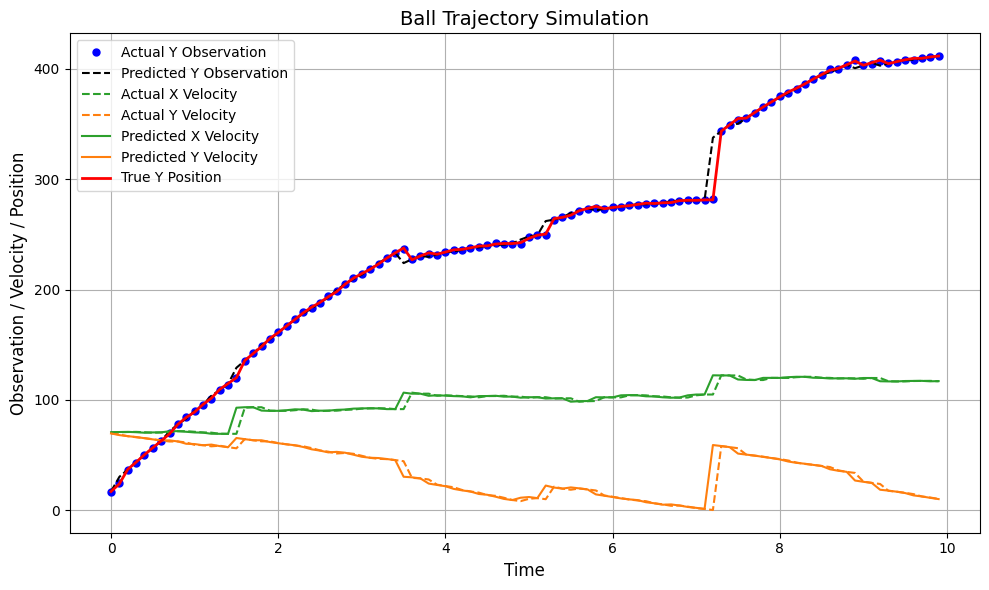

In [11]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [10,10]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=10.0, dt=0.1, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [12]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 6.08
MAE: 1.58



Time: 0.00
Actual Observation: [37.06791419 56.91873666]
Predicted Observation: [37.0684709  56.93697788]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.71, 69.73)

Time: 0.10
Actual Observation: [44.09626948 63.40312714]
Predicted Observation: [44.10479825 63.4933518 ]
Actual Velocity (X, Y): (70.71, 68.75)
Predicted Velocity (X, Y): (70.71, 68.70)

Time: 0.20
Actual Observation: [51.12783855 70.45407271]
Predicted Observation: [51.13717677 70.4267372 ]
Actual Velocity (X, Y): (70.71, 67.72)
Predicted Velocity (X, Y): (70.70, 67.75)

Time: 0.30
Actual Observation: [58.49677084 77.44235664]
Predicted Observation: [58.4404385  77.38600989]
Actual Velocity (X, Y): (70.70, 66.77)
Predicted Velocity (X, Y): (70.77, 66.84)

Time: 0.40
Actual Observation: [65.37989953 83.31282166]
Predicted Observation: [65.40638563 83.4492697 ]
Actual Velocity (X, Y): (70.77, 65.86)
Predicted Velocity (X, Y): (70.73, 65.64)

Time: 0.50
Actual Observation: [72.1444498  90.77014769]
Pre

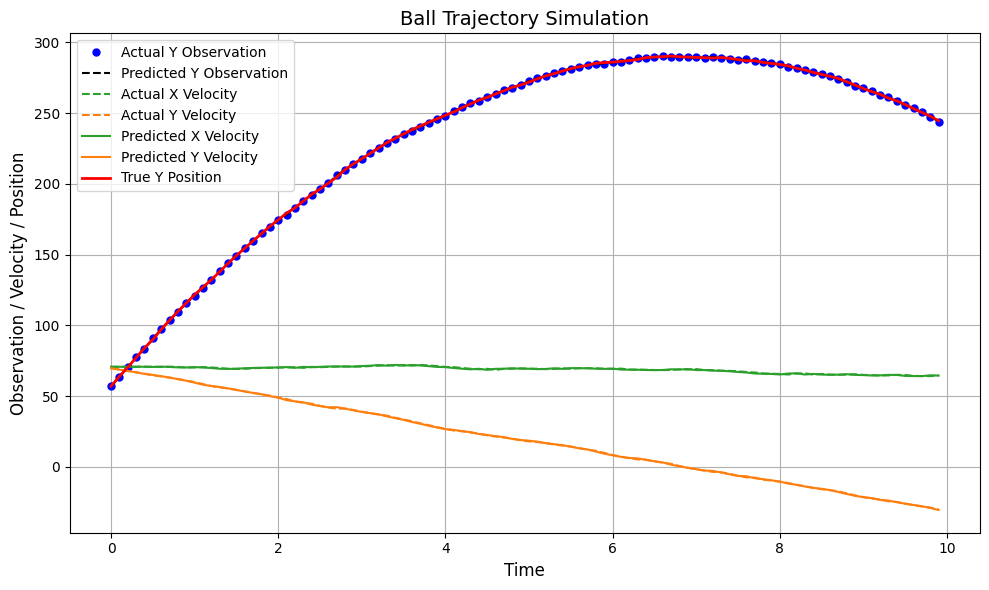

In [13]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [30, 50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=10.0, dt=0.1, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [14]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 0.08
MAE: 0.06



Time: 0.00
Actual Observation: [ -3.80446736 -73.31086067]
Predicted Observation: [ -3.37212753 -73.14646037]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.67, 69.71)

Time: 0.10
Actual Observation: [  3.71248451 -65.79902415]
Predicted Observation: [  3.70064281 -66.07911643]
Actual Velocity (X, Y): (70.67, 68.73)
Predicted Velocity (X, Y): (70.67, 68.78)

Time: 0.20
Actual Observation: [ 10.95889915 -59.08775582]
Predicted Observation: [ 10.81834467 -59.20723591]
Actual Velocity (X, Y): (70.67, 67.80)
Predicted Velocity (X, Y): (70.70, 67.82)

Time: 0.30
Actual Observation: [ 17.77579834 -52.23329929]
Predicted Observation: [ 17.86236984 -52.41927434]
Actual Velocity (X, Y): (70.70, 66.84)
Predicted Velocity (X, Y): (70.68, 66.88)

Time: 0.40
Actual Observation: [ 25.43705002 -46.63429854]
Predicted Observation: [ 25.03624067 -45.95897835]
Actual Velocity (X, Y): (70.68, 65.90)
Predicted Velocity (X, Y): (70.79, 65.72)

Time: 0.50
Actual Observation: [ 32.4790

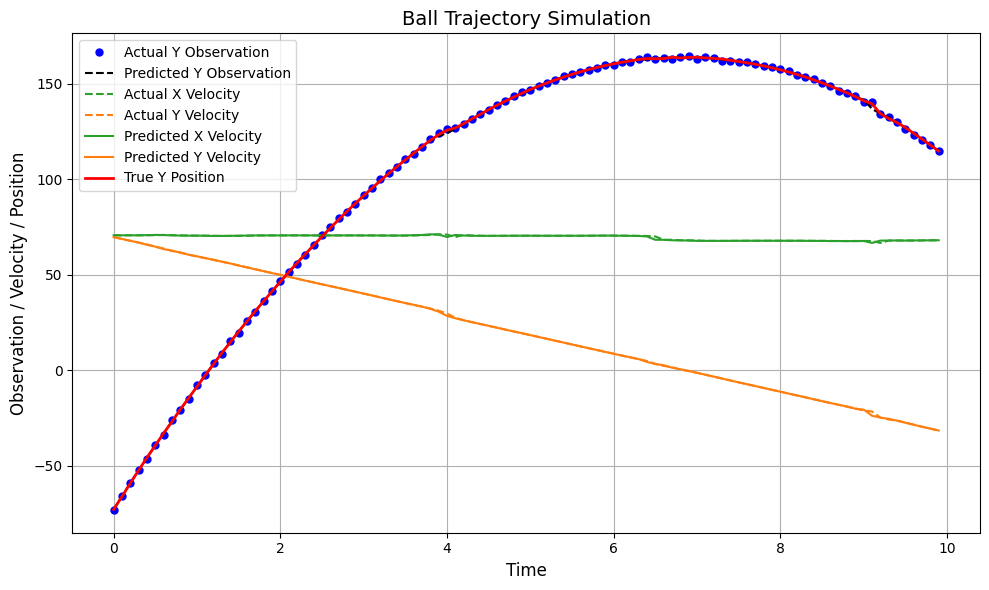

In [15]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [-10, -80]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=10.0, dt=0.1, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [16]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 0.61
MAE: 0.39



### 3.1.2 Differenet Observation Interval

Time: 0.00
Actual Observation: [ 83.84654185 109.69428125]
Predicted Observation: [ 83.93004733 109.70383346]
Actual Velocity (X, Y): (70.71, 61.89)
Predicted Velocity (X, Y): (70.78, 61.90)

Time: 0.90
Actual Observation: [147.77204599 162.24154419]
Predicted Observation: [147.94982019 163.25501135]
Actual Velocity (X, Y): (70.78, 53.08)
Predicted Velocity (X, Y): (71.11, 54.98)

Time: 1.80
Actual Observation: [212.24400346 208.19039368]
Predicted Observation: [212.1943644  208.28771186]
Actual Velocity (X, Y): (71.11, 46.16)
Predicted Velocity (X, Y): (71.24, 45.91)

Time: 2.70
Actual Observation: [276.57650572 245.4278196 ]
Predicted Observation: [276.76677631 245.27959366]
Actual Velocity (X, Y): (71.24, 37.09)
Predicted Velocity (X, Y): (71.62, 36.79)

Time: 3.60
Actual Observation: [340.9905601  274.94361671]
Predicted Observation: [341.09954048 274.70282927]
Actual Velocity (X, Y): (71.62, 27.97)
Predicted Velocity (X, Y): (71.63, 27.96)

Time: 4.50
Actual Observation: [405.2618

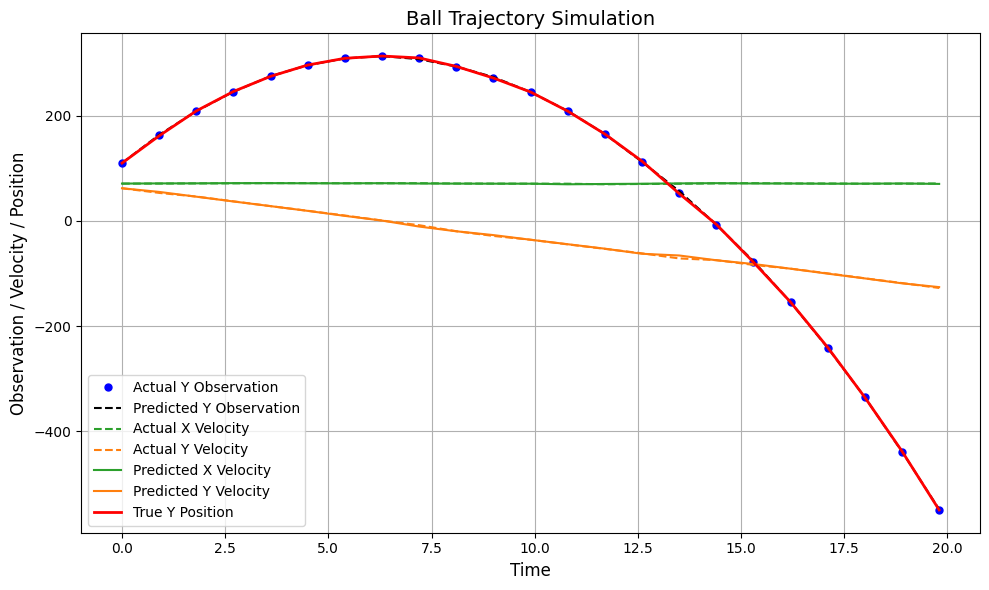

In [17]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [20, 50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=20.0, dt=0.9, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [18]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 1.07
MAE: 0.57



Time: 0.00
Actual Observation: [69.68323702 97.01717208]
Predicted Observation: [69.69696323 97.01131232]
Actual Velocity (X, Y): (70.71, 63.85)
Predicted Velocity (X, Y): (70.77, 63.82)

Time: 0.70
Actual Observation: [118.1439101 139.3109249]
Predicted Observation: [117.9946666  139.31413227]
Actual Velocity (X, Y): (70.77, 56.96)
Predicted Velocity (X, Y): (69.79, 56.99)

Time: 1.40
Actual Observation: [166.20849643 177.17665346]
Predicted Observation: [166.1023855  177.23899172]
Actual Velocity (X, Y): (69.79, 50.13)
Predicted Velocity (X, Y): (69.22, 50.46)

Time: 2.10
Actual Observation: [214.21355816 209.8576225 ]
Predicted Observation: [214.15754844 209.80777666]
Actual Velocity (X, Y): (69.22, 43.60)
Predicted Velocity (X, Y): (68.91, 43.33)

Time: 2.80
Actual Observation: [262.38807076 238.02348115]
Predicted Observation: [262.38733523 238.07121727]
Actual Velocity (X, Y): (68.91, 36.47)
Predicted Velocity (X, Y): (68.90, 36.73)

Time: 3.50
Actual Observation: [310.53460642 2

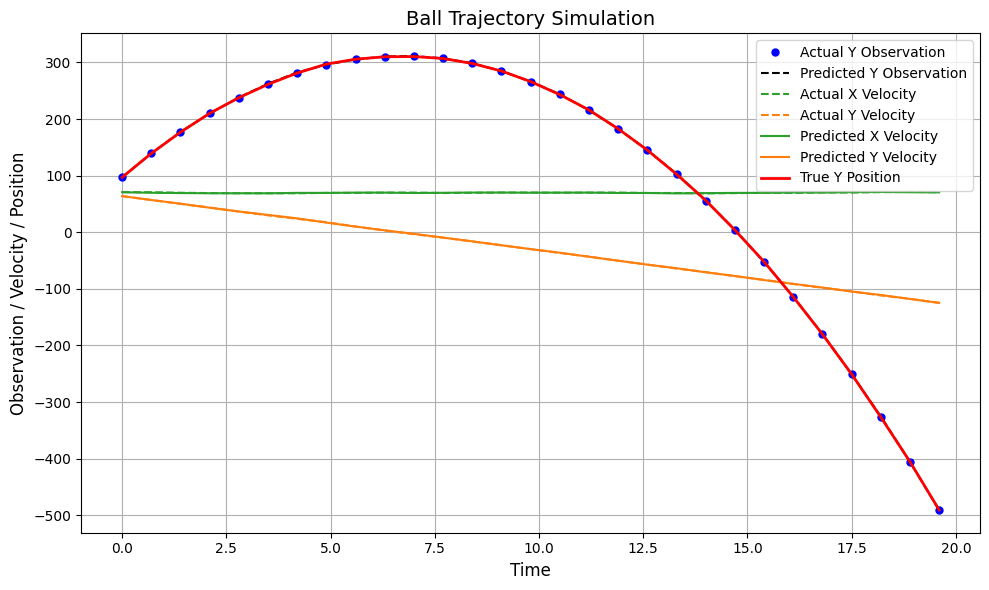

In [19]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [20, 50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=20.0, dt=0.7, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [20]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 0.07
MAE: 0.06



Time: 0.00
Actual Observation: [54.9451513  83.81900731]
Predicted Observation: [55.03717144 83.88885043]
Actual Velocity (X, Y): (70.71, 65.81)
Predicted Velocity (X, Y): (70.56, 65.69)

Time: 0.50
Actual Observation: [ 90.46667508 115.58859674]
Predicted Observation: [ 90.3895064 115.5489196]
Actual Velocity (X, Y): (70.56, 60.79)
Predicted Velocity (X, Y): (70.66, 60.85)

Time: 1.00
Actual Observation: [126.15850451 144.95318935]
Predicted Observation: [125.88176352 144.82358412]
Actual Velocity (X, Y): (70.66, 55.95)
Predicted Velocity (X, Y): (70.91, 56.06)

Time: 1.50
Actual Observation: [161.72060063 171.05834708]
Predicted Observation: [161.33900946 171.62340805]
Actual Velocity (X, Y): (70.91, 51.16)
Predicted Velocity (X, Y): (70.96, 51.09)

Time: 2.00
Actual Observation: [196.62535058 196.86661633]
Predicted Observation: [200.19340491 179.6656786 ]
Actual Velocity (X, Y): (70.96, 46.19)
Predicted Velocity (X, Y): (73.27, 35.02)

Time: 2.50
Actual Observation: [237.0255608  1

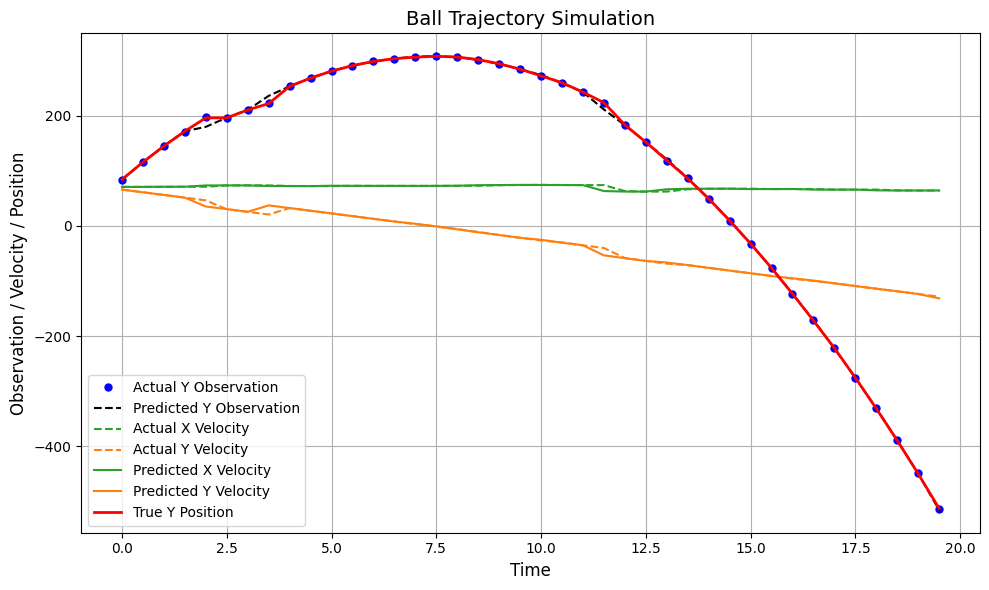

In [21]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [20, 50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=20.0, dt=0.5, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [22]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 3.85
MAE: 1.35



Time: 0.00
Actual Observation: [26.79753499 57.02203005]
Predicted Observation: [26.1101585  57.02193515]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.66, 69.73)

Time: 0.10
Actual Observation: [33.11564197 62.94170954]
Predicted Observation: [33.13128598 63.20104068]
Actual Velocity (X, Y): (70.66, 68.75)
Predicted Velocity (X, Y): (70.66, 68.74)

Time: 0.20
Actual Observation: [39.73695905 70.11005561]
Predicted Observation: [40.17099171 70.03074266]
Actual Velocity (X, Y): (70.66, 67.76)
Predicted Velocity (X, Y): (70.74, 67.74)

Time: 0.30
Actual Observation: [46.58539554 77.38932863]
Predicted Observation: [48.58337462 75.47227778]
Actual Velocity (X, Y): (70.74, 66.76)
Predicted Velocity (X, Y): (71.65, 65.89)

Time: 0.40
Actual Observation: [55.99629684 81.75523197]
Predicted Observation: [56.11968251 81.6270972 ]
Actual Velocity (X, Y): (71.65, 64.91)
Predicted Velocity (X, Y): (71.87, 64.68)

Time: 0.50
Actual Observation: [63.19685079 88.97712481]
Pre

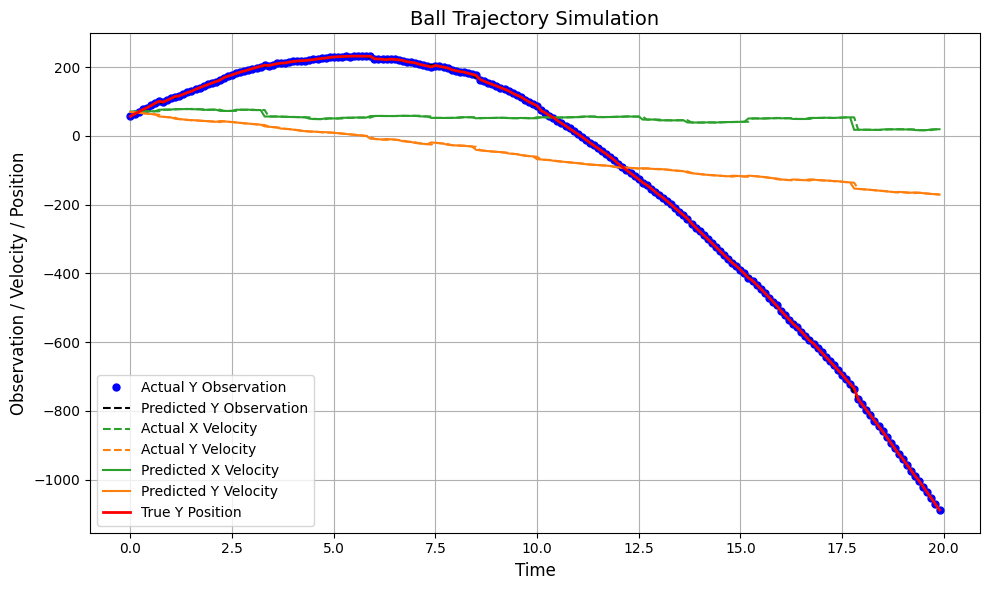

In [23]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [20, 50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=20.0, dt=0.1, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [24]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 1.86
MAE: 0.77



### 3.1.2 Skip_observation = True


Time: 0.00
Actual Observation: [17.62691868 17.11254638]
Predicted Observation: [17.01353763 17.01270334]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.67, 69.72)

Time: 0.10
Actual Observation: [24.74670212 24.43053326]
Predicted Observation: [24.30093984 24.099782  ]
Actual Velocity (X, Y): (70.67, 68.74)
Predicted Velocity (X, Y): (70.63, 68.72)

Time: 0.20
Actual Observation: [31.05535617 30.32884002]
Predicted Observation: [31.21440616 30.63480977]
Actual Velocity (X, Y): (70.63, 67.74)
Predicted Velocity (X, Y): (70.63, 67.74)

Time: 0.30
Actual Observation: [38.48374107 37.04324725]
Predicted Observation: [38.38595102 37.19313199]
Actual Velocity (X, Y): (70.63, 66.76)
Predicted Velocity (X, Y): (70.64, 66.74)

Time: 0.40
Actual Observation: [45.63837195 43.45259738]
Predicted Observation: [45.55152858 43.62115997]
Actual Velocity (X, Y): (70.64, 65.76)
Predicted Velocity (X, Y): (70.66, 65.72)

Time: 0.50
Actual Observation: [52.18695778 50.07389096]
Pre

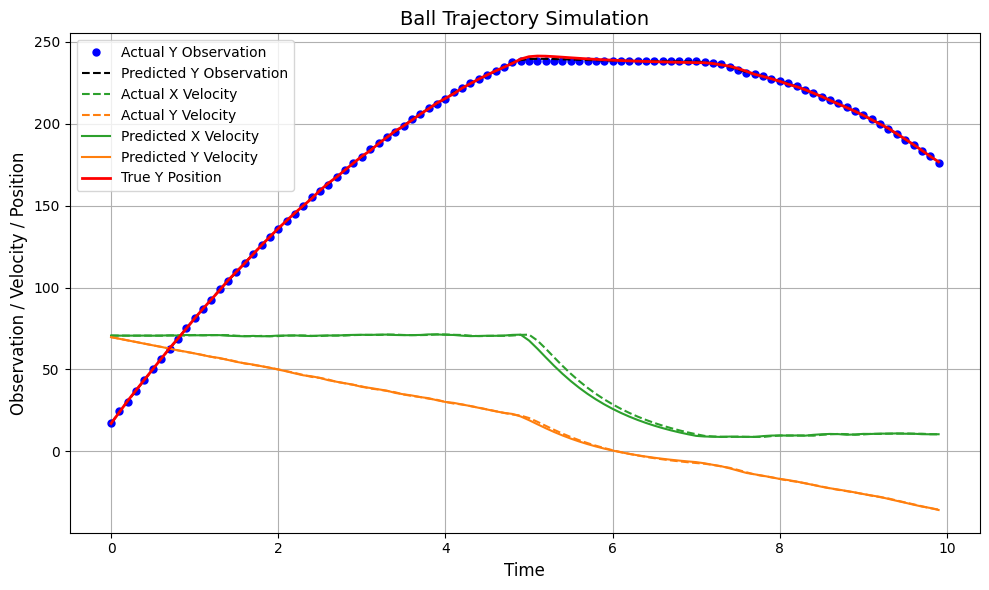

In [25]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [10,10]
launch_speed = 100
launch_angle = 45
start_ob_time = 5
stop_ob_time = 7
skip_observations = True

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=10.0, dt=0.1, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [26]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 0.33
MAE: 0.22



Time: 0.00
Actual Observation: [16.84358622 16.62394478]
Predicted Observation: [16.89060819 16.70623949]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.70, 69.71)

Time: 0.10
Actual Observation: [23.56190403 23.36185139]
Predicted Observation: [23.7179567  23.46602862]
Actual Velocity (X, Y): (70.70, 68.73)
Predicted Velocity (X, Y): (70.63, 68.68)

Time: 0.20
Actual Observation: [31.88777957 29.84039815]
Predicted Observation: [31.42562497 30.02596454]
Actual Velocity (X, Y): (70.63, 67.70)
Predicted Velocity (X, Y): (70.91, 67.58)

Time: 0.30
Actual Observation: [38.64976366 36.37840071]
Predicted Observation: [38.59416398 36.5276639 ]
Actual Velocity (X, Y): (70.91, 66.60)
Predicted Velocity (X, Y): (70.95, 66.49)

Time: 0.40
Actual Observation: [45.43650242 42.77483227]
Predicted Observation: [45.5415721  42.92146469]
Actual Velocity (X, Y): (70.95, 65.51)
Predicted Velocity (X, Y): (70.86, 65.39)

Time: 0.50
Actual Observation: [53.02847671 49.60065794]
Pre

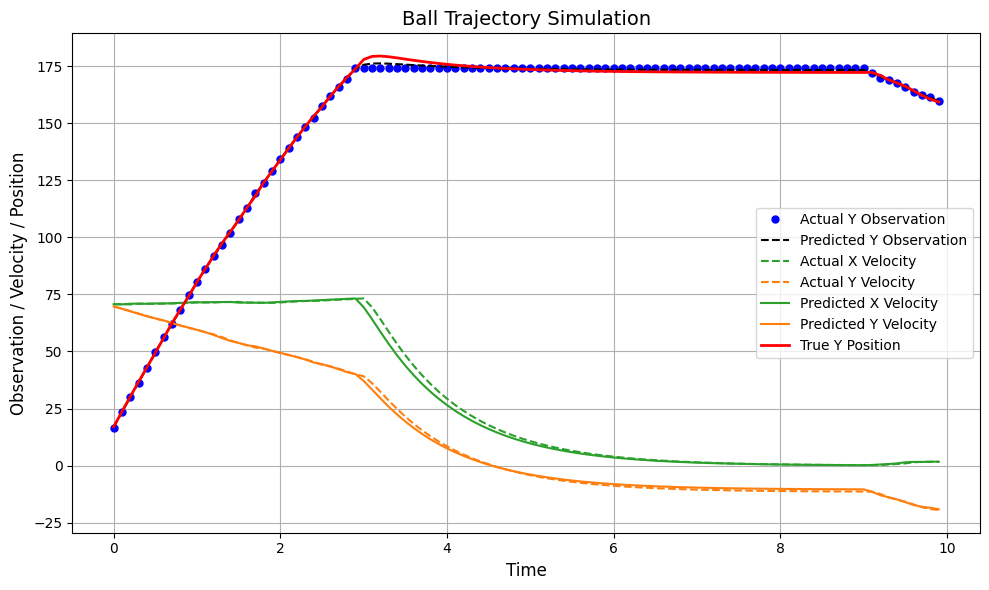

In [27]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [10,10]
launch_speed = 100
launch_angle = 45
start_ob_time = 3
stop_ob_time = 9
skip_observations = True

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=10.0, dt=0.1, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [28]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 0.67
MAE: 0.49



Time: 0.00
Actual Observation: [-49.00326644 -45.48101806]
Predicted Observation: [-90.51910627 -41.31983452]
Actual Velocity (X, Y): (42.43, 41.45)
Predicted Velocity (X, Y): (36.50, 42.04)

Time: 0.10
Actual Observation: [-87.91139859 -35.46978995]
Predicted Observation: [-87.84417655 -35.5790768 ]
Actual Velocity (X, Y): (36.50, 41.06)
Predicted Velocity (X, Y): (36.39, 41.25)

Time: 0.20
Actual Observation: [-85.26238586 -32.45620532]
Predicted Observation: [-84.8057796  -32.04436024]
Actual Velocity (X, Y): (36.39, 40.27)
Predicted Velocity (X, Y): (36.36, 40.25)

Time: 0.30
Actual Observation: [-80.46010413 -24.62586299]
Predicted Observation: [-80.82720055 -26.40745825]
Actual Velocity (X, Y): (36.36, 39.27)
Predicted Velocity (X, Y): (36.36, 39.26)

Time: 0.40
Actual Observation: [-79.36837181 -20.49531439]
Predicted Observation: [-78.18857652 -21.59812514]
Actual Velocity (X, Y): (36.36, 38.28)
Predicted Velocity (X, Y): (36.35, 38.29)

Time: 0.50
Actual Observation: [-72.8048

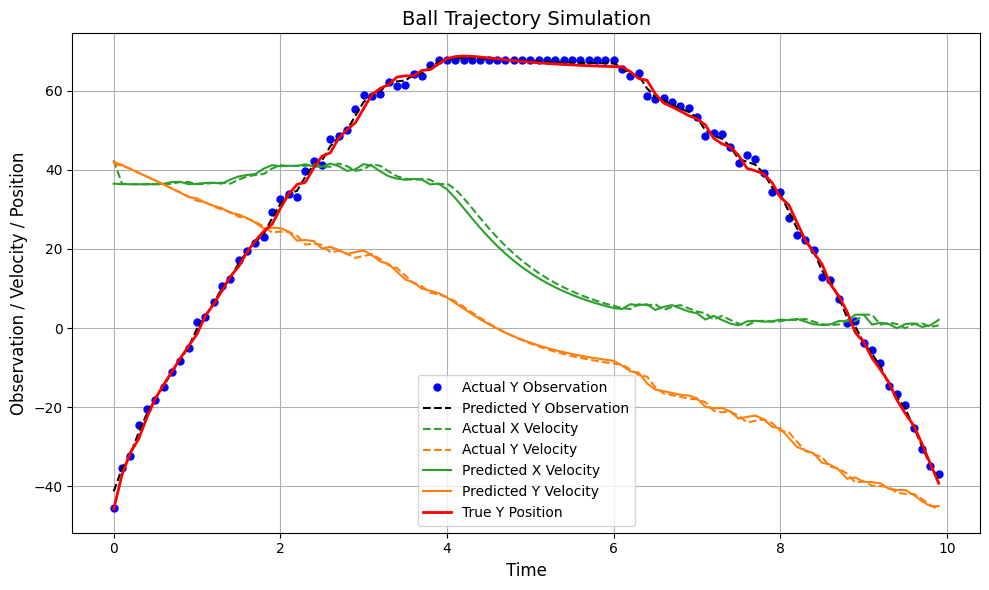

In [29]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 2
launch_position = [-50,-50]
launch_speed = 60
launch_angle = 45
start_ob_time = 4
stop_ob_time = 6
skip_observations = True

observations, predicted_observations= simulate_ball_trajectory(launch_position, launch_speed, launch_angle, total_time=10.0, dt=0.1, 
                                                                                                                         observation_time_step=0.5, 
                                                                                                                         observation_error_std=Observation_noise, R_val=P, Q_val=Q, 
                                                                                                                         skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                         skip_observations = skip_observations)


In [30]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy(observations, predicted_observations)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()


Observation Loss:
RMSE: 0.97
MAE: 0.75



## 3.2 Particle Filter 1 ball

### 3.2.1 Skip_observation = False | no of particles: 5000 | Different launch angles


C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.particles = [np.dot(A, particle) + np.dot(B, a) + np.random.multivariate_normal(np.zeros(particle.shape[0]), self.transition_covariance) for particle in self.particles]


Time: 0.00
Actual Observation: [17.10036042 17.1069343 ]
Predicted Observation: [17.94244612 17.4997472 ]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.56, 69.69)

Time: 0.10
Actual Observation: [24.66448721 24.18140085]
Predicted Observation: [25.93302366 25.92173401]
Actual Velocity (X, Y): (70.56, 68.71)
Predicted Velocity (X, Y): (71.62, 70.30)

Time: 0.20
Actual Observation: [33.94182656 33.36738181]
Predicted Observation: [27.49485335 28.12807648]
Actual Velocity (X, Y): (71.62, 69.32)
Predicted Velocity (X, Y): (67.97, 66.53)

Time: 0.30
Actual Observation: [33.84929451 34.74259131]
Predicted Observation: [33.339556   33.77800733]
Actual Velocity (X, Y): (67.97, 65.55)
Predicted Velocity (X, Y): (67.02, 64.59)

Time: 0.40
Actual Observation: [40.17862385 40.07912394]
Predicted Observation: [39.07013526 39.21688471]
Actual Velocity (X, Y): (67.02, 63.61)
Predicted Velocity (X, Y): (66.06, 62.65)

Time: 0.50
Actual Observation: [45.74868605 45.70900666]
Pre

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]
C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:51: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)


Time: 0.90
Actual Observation: [68.15329269 66.09194044]
Predicted Observation: [67.46934809 64.68758814]
Actual Velocity (X, Y): (62.93, 54.62)
Predicted Velocity (X, Y): (62.27, 53.97)

Time: 1.00
Actual Observation: [73.34871115 69.93699165]
Predicted Observation: [73.65963677 69.99817494]
Actual Velocity (X, Y): (62.27, 52.99)
Predicted Velocity (X, Y): (62.24, 52.95)

Time: 1.10
Actual Observation: [80.53307905 75.19633873]
Predicted Observation: [79.8774911  75.23832738]
Actual Velocity (X, Y): (62.24, 51.97)
Predicted Velocity (X, Y): (62.23, 51.96)

Time: 1.20
Actual Observation: [85.69454154 79.57073447]
Predicted Observation: [86.08815149 80.37328589]
Actual Velocity (X, Y): (62.23, 50.98)
Predicted Velocity (X, Y): (62.22, 50.97)

Time: 1.30
Actual Observation: [92.19887244 85.82126515]
Predicted Observation: [92.30476783 85.41620035]
Actual Velocity (X, Y): (62.22, 49.99)
Predicted Velocity (X, Y): (62.21, 49.99)

Time: 1.40
Actual Observation: [98.39695717 91.14466372]
Pre

Time: 5.20
Actual Observation: [335.72489252 206.60595408]
Predicted Observation: [335.98806242 206.88512157]
Actual Velocity (X, Y): (62.49, 12.04)
Predicted Velocity (X, Y): (62.50, 12.05)

Time: 5.30
Actual Observation: [342.41229459 207.70075083]
Predicted Observation: [342.19086037 207.99421764]
Actual Velocity (X, Y): (62.50, 11.07)
Predicted Velocity (X, Y): (62.48, 11.05)

Time: 5.40
Actual Observation: [348.6904691  208.77850835]
Predicted Observation: [348.40251325 209.01416864]
Actual Velocity (X, Y): (62.48, 10.07)
Predicted Velocity (X, Y): (62.48, 10.08)

Time: 5.50
Actual Observation: [354.21334399 209.7576366 ]
Predicted Observation: [354.51448635 209.83643986]
Actual Velocity (X, Y): (62.48, 9.10)
Predicted Velocity (X, Y): (62.46, 9.07)

Time: 5.60
Actual Observation: [360.06214533 210.89667207]
Predicted Observation: [360.60023413 210.53448576]
Actual Velocity (X, Y): (62.46, 8.09)
Predicted Velocity (X, Y): (62.40, 8.04)

Time: 5.70
Actual Observation: [367.33686195

Time: 9.50
Actual Observation: [602.00190515 166.41254889]
Predicted Observation: [603.01947036 166.39334862]
Actual Velocity (X, Y): (62.17, -30.41)
Predicted Velocity (X, Y): (62.26, -30.33)

Time: 9.60
Actual Observation: [608.45777476 163.68933803]
Predicted Observation: [609.16076525 163.22694163]
Actual Velocity (X, Y): (62.26, -31.31)
Predicted Velocity (X, Y): (62.26, -31.31)

Time: 9.70
Actual Observation: [614.96173505 160.12108857]
Predicted Observation: [616.13111886 160.79159336]
Actual Velocity (X, Y): (62.26, -32.29)
Predicted Velocity (X, Y): (62.39, -32.16)

Time: 9.80
Actual Observation: [621.91069888 157.32415442]
Predicted Observation: [622.60129365 157.75806626]
Actual Velocity (X, Y): (62.39, -33.14)
Predicted Velocity (X, Y): (62.41, -33.11)

Time: 9.90
Actual Observation: [629.19921656 154.69269475]
Predicted Observation: [629.06371355 154.61878428]
Actual Velocity (X, Y): (62.41, -34.09)
Predicted Velocity (X, Y): (62.43, -34.08)

Time: 10.00
Actual Observation

Time: 13.80
Actual Observation: [872.35922935 -52.99584216]
Predicted Observation: [871.70778651 -53.64351612]
Actual Velocity (X, Y): (62.49, -72.23)
Predicted Velocity (X, Y): (62.39, -72.34)

Time: 13.90
Actual Observation: [876.94964873 -60.89315053]
Predicted Observation: [878.12379396 -60.74921055]
Actual Velocity (X, Y): (62.39, -73.32)
Predicted Velocity (X, Y): (62.39, -73.32)

Time: 14.00
Actual Observation: [884.51869346 -67.54947889]
Predicted Observation: [885.06723024 -67.42547615]
Actual Velocity (X, Y): (62.39, -74.30)
Predicted Velocity (X, Y): (62.49, -74.20)

Time: 14.10
Actual Observation: [891.46699517 -76.22415757]
Predicted Observation: [891.60883663 -74.60157164]
Actual Velocity (X, Y): (62.49, -75.18)
Predicted Velocity (X, Y): (62.52, -75.14)

Time: 14.20
Actual Observation: [897.84068469 -81.92093403]
Predicted Observation: [897.50481641 -82.52129375]
Actual Velocity (X, Y): (62.52, -76.12)
Predicted Velocity (X, Y): (62.49, -76.16)

Time: 14.30
Actual Observ

Time: 18.00
Actual Observation: [1129.83619155 -448.05389885]
Predicted Observation: [1129.70853463 -447.93224701]
Actual Velocity (X, Y): (62.32, -113.57)
Predicted Velocity (X, Y): (62.28, -113.60)

Time: 18.10
Actual Observation: [1136.16061835 -458.95838193]
Predicted Observation: [1135.93961522 -459.33886831]
Actual Velocity (X, Y): (62.28, -114.58)
Predicted Velocity (X, Y): (62.27, -114.59)

Time: 18.20
Actual Observation: [1142.23885613 -470.84608205]
Predicted Observation: [1142.11787689 -470.89630851]
Actual Velocity (X, Y): (62.27, -115.57)
Predicted Velocity (X, Y): (62.24, -115.61)

Time: 18.30
Actual Observation: [1148.76402391 -482.69260809]
Predicted Observation: [1150.05788768 -480.78999961]
Actual Velocity (X, Y): (62.24, -116.59)
Predicted Velocity (X, Y): (62.37, -116.46)

Time: 18.40
Actual Observation: [1155.81138972 -492.31736025]
Predicted Observation: [1155.35865488 -493.42093428]
Actual Velocity (X, Y): (62.37, -117.44)
Predicted Velocity (X, Y): (62.41, -117.

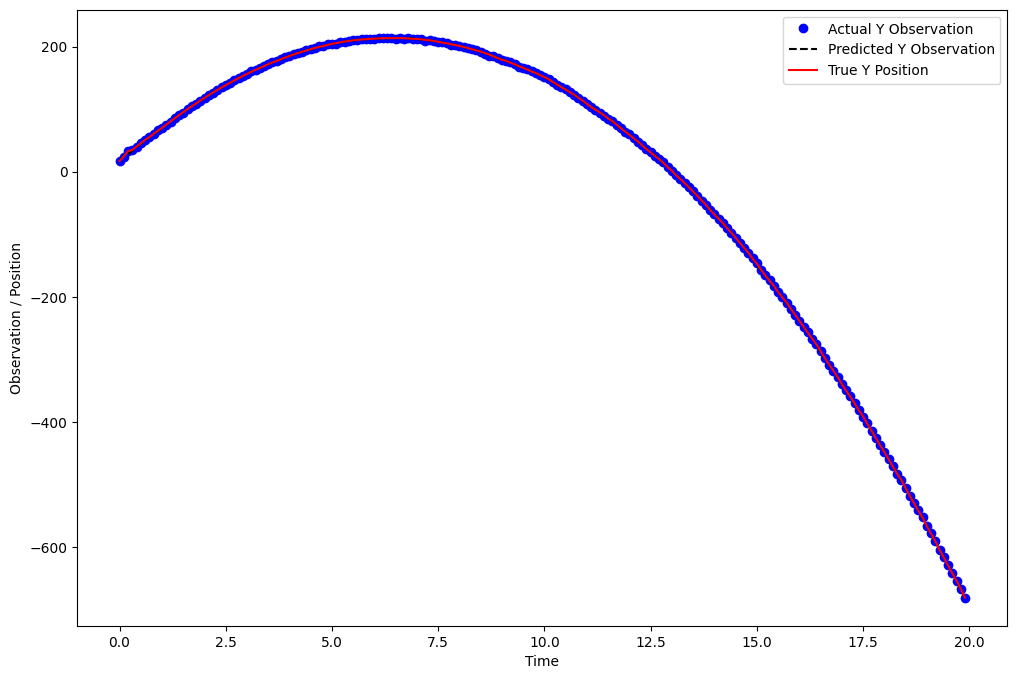

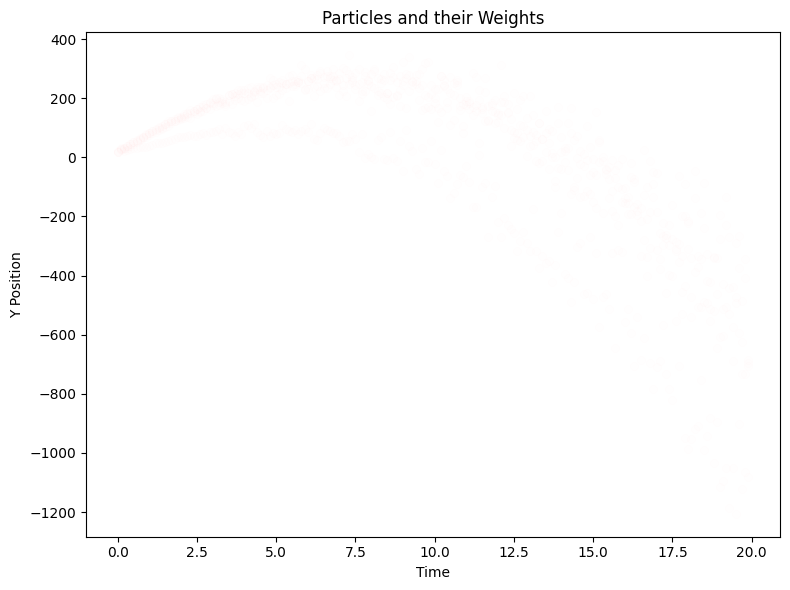

In [31]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
no_particles = 5000
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [10,10]
launch_speed = 100
launch_angle = 45
start_ob_time = 5
stop_ob_time = 7
skip_observations = False
observations_ball1_1, predicted_observations_ball1_1 = simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle,no_particles= no_particles, total_time=20.0, dt=0.1, observation_time_step=0.5, observation_error_std=Observation_noise, R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,skip_observations = skip_observations)

In [32]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy_particle(observations_ball1_1, predicted_observations_ball1_1)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 0.79
MAE: 0.57



Time: 0.00
Actual Observation: [36.97848368 56.46155155]
Predicted Observation: [38.17874114 59.30074902]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (72.87, 69.81)

Time: 0.10
Actual Observation: [45.9237974 66.4740217]
Predicted Observation: [46.14627115 66.91315228]
Actual Velocity (X, Y): (72.87, 68.83)
Predicted Velocity (X, Y): (73.55, 69.51)

Time: 0.20
Actual Observation: [54.58707553 73.51631753]
Predicted Observation: [53.99183237 74.30558675]
Actual Velocity (X, Y): (73.55, 68.53)
Predicted Velocity (X, Y): (74.05, 69.03)



C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]
C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:51: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)


Time: 0.30
Actual Observation: [60.3658029  81.02985185]
Predicted Observation: [61.92771396 81.69034159]
Actual Velocity (X, Y): (74.05, 68.05)
Predicted Velocity (X, Y): (74.58, 68.58)

Time: 0.40
Actual Observation: [70.43927481 88.21196538]
Predicted Observation: [69.61985491 88.7333558 ]
Actual Velocity (X, Y): (74.58, 67.60)
Predicted Velocity (X, Y): (74.81, 67.83)

Time: 0.50
Actual Observation: [76.19204193 95.65174003]
Predicted Observation: [77.09302636 95.4594005 ]
Actual Velocity (X, Y): (74.81, 66.85)
Predicted Velocity (X, Y): (74.81, 66.84)

Time: 0.60
Actual Observation: [ 84.3252021  102.32858066]
Predicted Observation: [ 84.58472234 102.10596972]
Actual Velocity (X, Y): (74.81, 65.86)
Predicted Velocity (X, Y): (74.82, 65.88)

Time: 0.70
Actual Observation: [ 91.59329875 108.8249797 ]
Predicted Observation: [ 92.06017884 108.63829948]
Actual Velocity (X, Y): (74.82, 64.90)
Predicted Velocity (X, Y): (74.82, 64.89)

Time: 0.80
Actual Observation: [ 98.58198357 115.297

Time: 4.60
Actual Observation: [382.1063014  286.33090676]
Predicted Observation: [382.67595413 286.03213157]
Actual Velocity (X, Y): (74.39, 26.25)
Predicted Velocity (X, Y): (74.42, 26.28)

Time: 4.70
Actual Observation: [390.52037199 288.4594701 ]
Predicted Observation: [390.29799966 288.79105036]
Actual Velocity (X, Y): (74.42, 25.30)
Predicted Velocity (X, Y): (74.49, 25.36)

Time: 4.80
Actual Observation: [397.55080166 291.88424018]
Predicted Observation: [397.65523781 291.18716175]
Actual Velocity (X, Y): (74.49, 24.38)
Predicted Velocity (X, Y): (74.46, 24.36)

Time: 4.90
Actual Observation: [405.20599244 293.60016729]
Predicted Observation: [405.27814096 293.75093815]
Actual Velocity (X, Y): (74.46, 23.38)
Predicted Velocity (X, Y): (74.51, 23.43)

Time: 5.00
Actual Observation: [412.61575018 295.13375901]
Predicted Observation: [412.97163969 296.28731014]
Actual Velocity (X, Y): (74.51, 22.45)
Predicted Velocity (X, Y): (74.58, 22.52)

Time: 5.10
Actual Observation: [420.6489

Time: 8.90
Actual Observation: [700.96553335 307.26682129]
Predicted Observation: [702.01807693 307.76580418]
Actual Velocity (X, Y): (74.36, -15.92)
Predicted Velocity (X, Y): (74.43, -15.85)

Time: 9.00
Actual Observation: [709.65840214 305.31411245]
Predicted Observation: [709.70876875 306.37936926]
Actual Velocity (X, Y): (74.43, -16.83)
Predicted Velocity (X, Y): (74.42, -16.84)

Time: 9.10
Actual Observation: [717.13323052 304.37936056]
Predicted Observation: [717.01740745 304.51288121]
Actual Velocity (X, Y): (74.42, -17.82)
Predicted Velocity (X, Y): (74.38, -17.86)

Time: 9.20
Actual Observation: [724.24978318 302.74546241]
Predicted Observation: [724.41235586 302.63470287]
Actual Velocity (X, Y): (74.38, -18.84)
Predicted Velocity (X, Y): (74.38, -18.85)

Time: 9.30
Actual Observation: [731.91252753 300.36390285]
Predicted Observation: [731.66566697 300.51688723]
Actual Velocity (X, Y): (74.38, -19.83)
Predicted Velocity (X, Y): (74.35, -19.85)

Time: 9.40
Actual Observation:

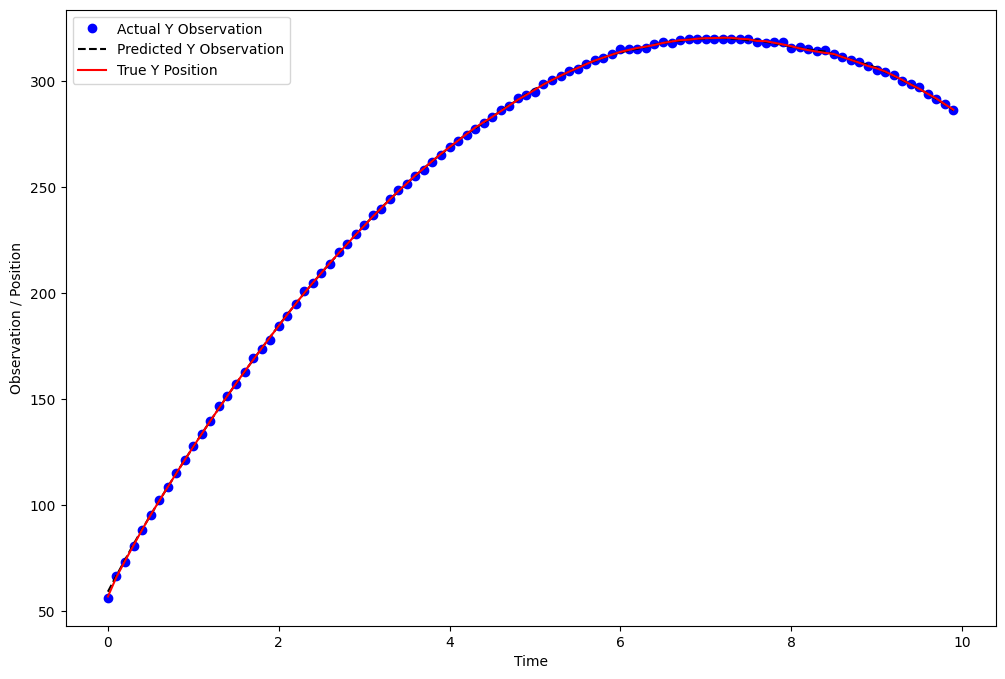

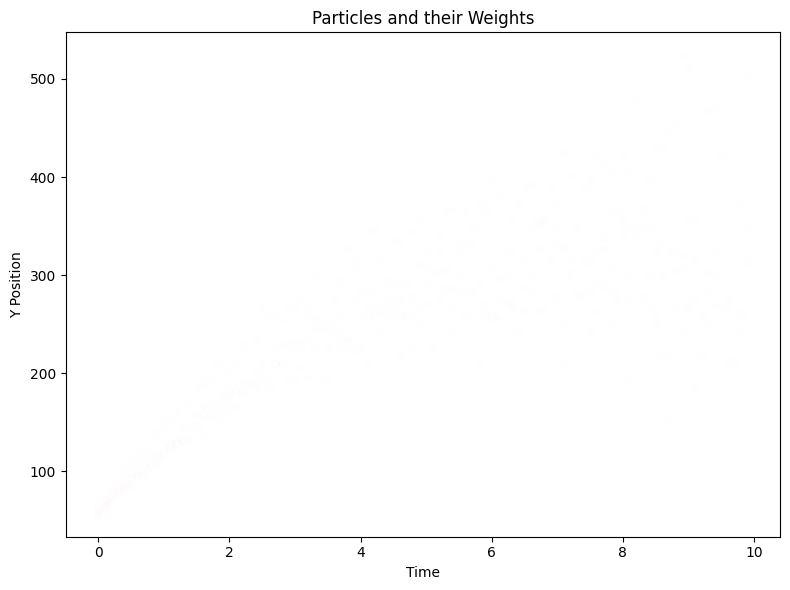

In [33]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
no_particles = 5000
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [30,50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False
observations_ball1_1, predicted_observations_ball1_1 = simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle,no_particles= no_particles, total_time=10.0, dt=0.1, observation_time_step=0.5, observation_error_std=Observation_noise, R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,skip_observations = skip_observations)

In [34]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy_particle(observations_ball1_1, predicted_observations_ball1_1)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 0.56
MAE: 0.40



Time: 0.00
Actual Observation: [ -2.88803418 -73.24113182]
Predicted Observation: [ -2.89887567 -73.16466054]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.77, 69.66)

Time: 0.10
Actual Observation: [  4.59365995 -66.14076538]
Predicted Observation: [  4.33261937 -66.21742121]
Actual Velocity (X, Y): (70.77, 68.68)
Predicted Velocity (X, Y): (70.87, 68.70)

Time: 0.20
Actual Observation: [ 11.69556348 -59.31945455]
Predicted Observation: [ 11.47070921 -59.40474579]
Actual Velocity (X, Y): (70.87, 67.72)
Predicted Velocity (X, Y): (70.94, 67.71)

Time: 0.30
Actual Observation: [ 19.36810887 -52.1957045 ]
Predicted Observation: [ 18.70556417 -52.62613634]
Actual Velocity (X, Y): (70.94, 66.73)
Predicted Velocity (X, Y): (71.12, 66.79)

Time: 0.40
Actual Observation: [ 25.45924177 -46.19286168]
Predicted Observation: [ 25.67847786 -46.09801979]
Actual Velocity (X, Y): (71.12, 65.81)
Predicted Velocity (X, Y): (70.93, 65.64)

Time: 0.50
Actual Observation: [ 32.7768

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]


Time: 3.30
Actual Observation: [231.68524718 102.37805813]
Predicted Observation: [231.4276942  102.68861978]
Actual Velocity (X, Y): (70.94, 37.15)
Predicted Velocity (X, Y): (70.94, 37.11)

Time: 3.40
Actual Observation: [239.34831845 106.41104405]
Predicted Observation: [238.54031386 106.29033603]
Actual Velocity (X, Y): (70.94, 36.13)
Predicted Velocity (X, Y): (70.98, 36.15)

Time: 3.50
Actual Observation: [245.80645185 109.48326832]
Predicted Observation: [245.52186673 109.68609127]
Actual Velocity (X, Y): (70.98, 35.17)
Predicted Velocity (X, Y): (70.92, 35.09)

Time: 3.60
Actual Observation: [252.66596569 113.03669147]
Predicted Observation: [252.57720822 113.08691554]
Actual Velocity (X, Y): (70.92, 34.11)
Predicted Velocity (X, Y): (70.88, 34.06)

Time: 3.70
Actual Observation: [260.23681027 116.32610032]
Predicted Observation: [259.62493244 116.33933247]
Actual Velocity (X, Y): (70.88, 33.08)
Predicted Velocity (X, Y): (70.88, 33.06)

Time: 3.80
Actual Observation: [265.4419

Time: 7.60
Actual Observation: [537.58721868 173.02969235]
Predicted Observation: [538.03380039 173.01612662]
Actual Velocity (X, Y): (71.37, -4.63)
Predicted Velocity (X, Y): (71.42, -4.58)

Time: 7.70
Actual Observation: [545.53352619 173.33190991]
Predicted Observation: [545.1497777  172.50024995]
Actual Velocity (X, Y): (71.42, -5.56)
Predicted Velocity (X, Y): (71.51, -5.47)

Time: 7.80
Actual Observation: [552.3427255  171.76492288]
Predicted Observation: [552.25493567 171.8550815 ]
Actual Velocity (X, Y): (71.51, -6.45)
Predicted Velocity (X, Y): (71.45, -6.51)

Time: 7.90
Actual Observation: [559.30529274 170.87075218]
Predicted Observation: [559.56574301 171.31492675]
Actual Velocity (X, Y): (71.45, -7.49)
Predicted Velocity (X, Y): (71.44, -7.51)

Time: 8.00
Actual Observation: [566.44250968 169.9443782 ]
Predicted Observation: [566.86377263 170.65592764]
Actual Velocity (X, Y): (71.44, -8.49)
Predicted Velocity (X, Y): (71.43, -8.50)

Time: 8.10
Actual Observation: [573.5604

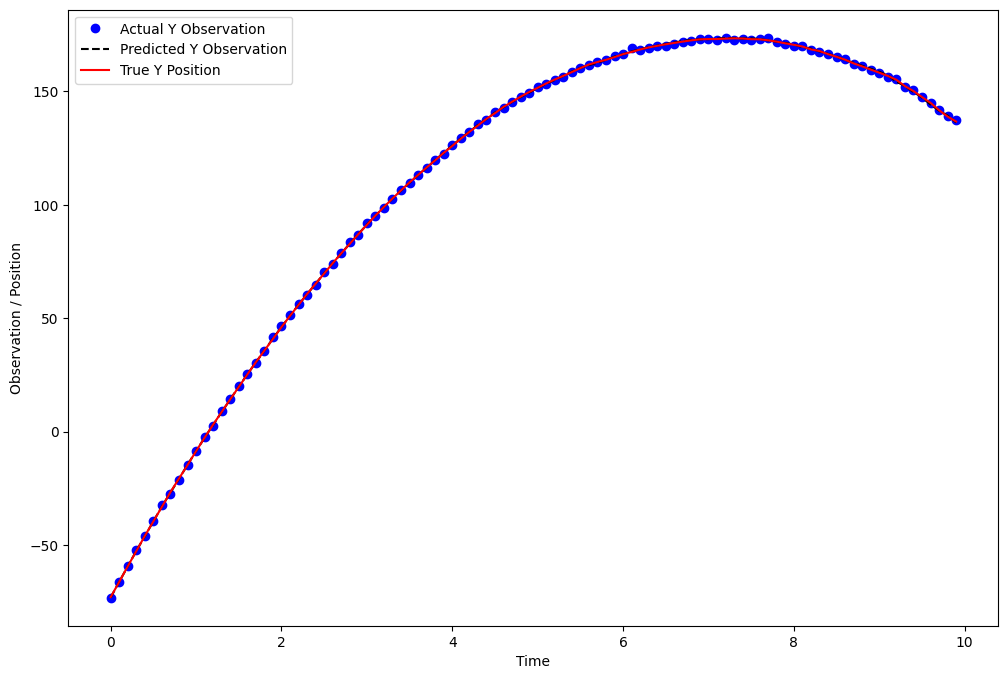

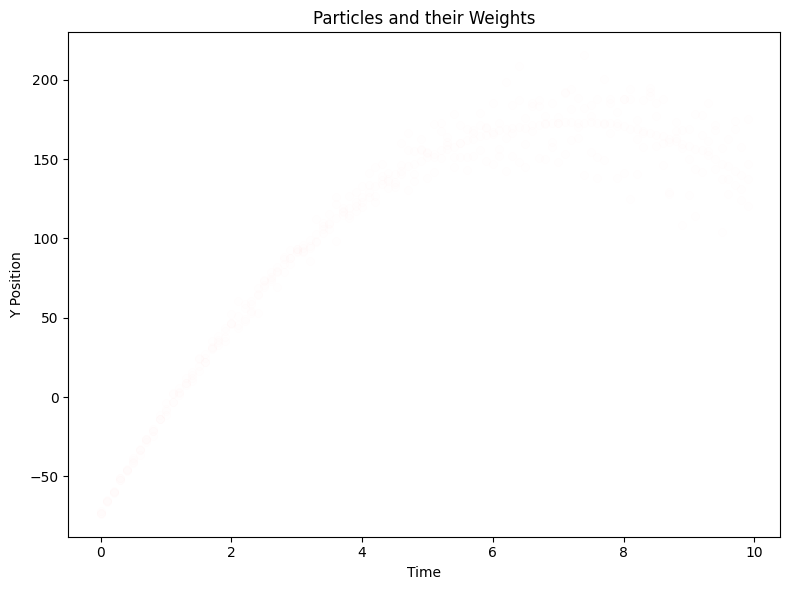

In [35]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
no_particles = 5000
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [-10,-80]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False
observations_ball1_1, predicted_observations_ball1_1 = simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle,no_particles= no_particles, total_time=10.0, dt=0.1, observation_time_step=0.5, observation_error_std=Observation_noise, R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,skip_observations = skip_observations)

In [36]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy_particle(observations_ball1_1, predicted_observations_ball1_1)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 0.47
MAE: 0.37



### 3.2.2 Skip_observation = False | no of particles: 5000 | Observation Interval


Time: 0.00
Actual Observation: [-11.991202   -19.19554505]
Predicted Observation: [ -7.51572346 -13.33708404]
Actual Velocity (X, Y): (42.43, 33.61)
Predicted Velocity (X, Y): (44.96, 34.32)

Time: 0.90
Actual Observation: [33.42448539 16.06315974]
Predicted Observation: [32.9448858  13.57707292]
Actual Velocity (X, Y): (44.96, 25.50)
Predicted Velocity (X, Y): (44.96, 25.49)

Time: 1.80
Actual Observation: [72.32919184 33.93860513]
Predicted Observation: [73.8984025  33.04613731]
Actual Velocity (X, Y): (44.96, 16.67)
Predicted Velocity (X, Y): (45.21, 16.93)

Time: 2.70
Actual Observation: [109.40112769  47.18245574]
Predicted Observation: [114.69809278  44.42337528]
Actual Velocity (X, Y): (45.21, 8.11)
Predicted Velocity (X, Y): (45.32, 8.22)

Time: 3.60
Actual Observation: [152.50047011  47.40019609]
Predicted Observation: [155.65459239  48.01942258]
Actual Velocity (X, Y): (45.32, -0.60)
Predicted Velocity (X, Y): (45.49, -0.43)

Time: 4.50
Actual Observation: [196.51058551  42.6

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]
C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:51: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)


Time: 5.40
Actual Observation: [235.37214784  31.83500978]
Predicted Observation: [237.87223292  31.7021585 ]
Actual Velocity (X, Y): (45.66, -17.90)
Predicted Velocity (X, Y): (45.67, -17.89)

Time: 6.30
Actual Observation: [282.59302443  14.38448834]
Predicted Observation: [279.02090159  11.67637486]
Actual Velocity (X, Y): (45.67, -26.71)
Predicted Velocity (X, Y): (45.70, -26.68)

Time: 7.20
Actual Observation: [318.36429489 -14.76563815]
Predicted Observation: [320.14168632 -16.31529272]
Actual Velocity (X, Y): (45.70, -35.50)
Predicted Velocity (X, Y): (45.69, -35.51)

Time: 8.10
Actual Observation: [362.08883589 -53.84065051]
Predicted Observation: [361.25873497 -52.24869638]
Actual Velocity (X, Y): (45.69, -44.33)
Predicted Velocity (X, Y): (45.69, -44.33)

Time: 9.00
Actual Observation: [403.32847644 -95.93708707]
Predicted Observation: [402.39693953 -96.09894412]
Actual Velocity (X, Y): (45.69, -53.15)
Predicted Velocity (X, Y): (45.70, -53.14)

Time: 9.90
Actual Observation:

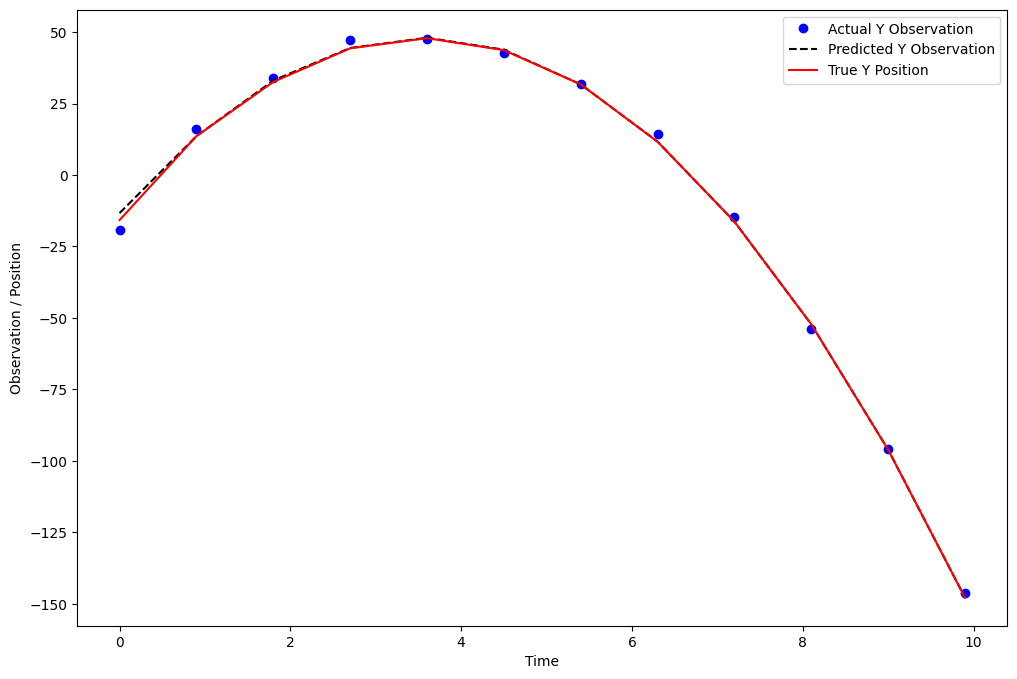

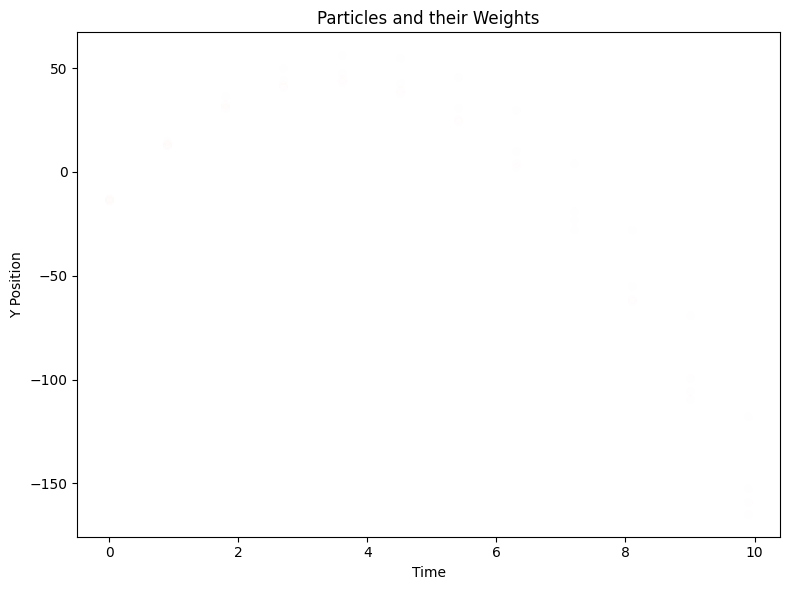

In [37]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
no_particles = 5000
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 2
launch_position = [-50,-50]
launch_speed = 60
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False
observations_ball1_1, predicted_observations_ball1_1 = simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle,no_particles= no_particles, total_time=10.0, dt=0.9, observation_time_step=0.5, observation_error_std=Observation_noise, R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,skip_observations = skip_observations)

In [38]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy_particle(observations_ball1_1, predicted_observations_ball1_1)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 2.33
MAE: 1.79



C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.particles = [np.dot(A, particle) + np.dot(B, a) + np.random.multivariate_normal(np.zeros(particle.shape[0]), self.transition_covariance) for particle in self.particles]


Time: 0.00
Actual Observation: [55.25554583 84.81444737]
Predicted Observation: [55.21657029 84.60440024]
Actual Velocity (X, Y): (70.71, 65.81)
Predicted Velocity (X, Y): (70.67, 65.95)

Time: 0.50
Actual Observation: [ 90.90873807 115.69168924]
Predicted Observation: [ 90.73902501 115.96607597]
Actual Velocity (X, Y): (70.67, 61.05)
Predicted Velocity (X, Y): (70.83, 60.73)

Time: 1.00
Actual Observation: [126.88352217 144.82095387]
Predicted Observation: [126.53334819 144.89854253]
Actual Velocity (X, Y): (70.83, 55.83)
Predicted Velocity (X, Y): (71.13, 55.67)

Time: 1.50
Actual Observation: [161.7917416  171.34902319]
Predicted Observation: [161.97086654 171.46532553]
Actual Velocity (X, Y): (71.13, 50.77)
Predicted Velocity (X, Y): (71.02, 50.72)

Time: 2.00
Actual Observation: [196.87021542 196.90194075]
Predicted Observation: [196.97581916 196.06542049]
Actual Velocity (X, Y): (71.02, 45.82)
Predicted Velocity (X, Y): (70.78, 46.13)

Time: 2.50
Actual Observation: [232.43786258

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]


Time: 6.50
Actual Observation: [515.39096107 303.3021666 ]
Predicted Observation: [515.45620822 303.16435567]
Actual Velocity (X, Y): (70.85, 1.87)
Predicted Velocity (X, Y): (70.81, 1.84)

Time: 7.00
Actual Observation: [550.39620158 303.47472699]
Predicted Observation: [550.86477505 303.17027028]
Actual Velocity (X, Y): (70.81, -3.06)
Predicted Velocity (X, Y): (70.79, -3.00)

Time: 7.50
Actual Observation: [586.29751669 300.12947697]
Predicted Observation: [586.12267155 300.25007777]
Actual Velocity (X, Y): (70.79, -7.90)
Predicted Velocity (X, Y): (70.78, -7.93)

Time: 8.00
Actual Observation: [621.3767962  294.31902533]
Predicted Observation: [621.09144591 294.50913028]
Actual Velocity (X, Y): (70.78, -12.83)
Predicted Velocity (X, Y): (70.68, -12.95)

Time: 8.50
Actual Observation: [657.33655671 286.37471512]
Predicted Observation: [656.12843003 286.12749765]
Actual Velocity (X, Y): (70.68, -17.85)
Predicted Velocity (X, Y): (70.67, -17.93)

Time: 9.00
Actual Observation: [691.01

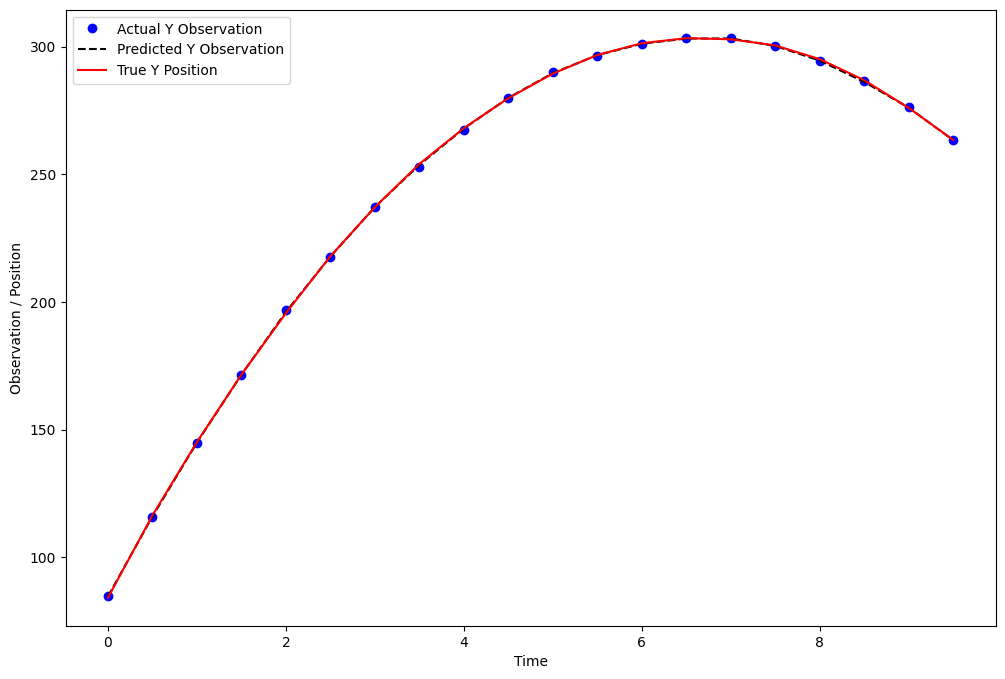

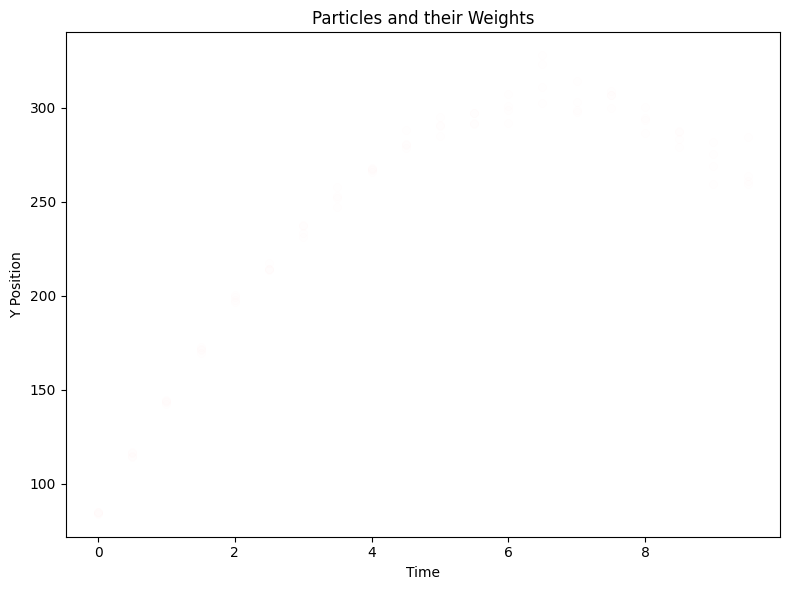

In [39]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
no_particles = 5000
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [20,50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False
observations_ball1_1, predicted_observations_ball1_1 = simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle,no_particles= no_particles, total_time=10.0, dt=0.5, observation_time_step=0.5, observation_error_std=Observation_noise, R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,skip_observations = skip_observations)

In [40]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy_particle(observations_ball1_1, predicted_observations_ball1_1)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 0.38
MAE: 0.29



Time: 0.00
Actual Observation: [26.53187393 56.37658634]
Predicted Observation: [30.56749173 59.68786887]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (71.56, 72.02)

Time: 0.10
Actual Observation: [37.85265704 67.51587681]
Predicted Observation: [40.34775806 69.32863091]
Actual Velocity (X, Y): (71.56, 71.04)
Predicted Velocity (X, Y): (74.09, 73.58)

Time: 0.20
Actual Observation: [47.44058415 76.73377707]
Predicted Observation: [50.05776406 78.93860664]
Actual Velocity (X, Y): (74.09, 72.60)
Predicted Velocity (X, Y): (76.39, 74.90)

Time: 0.30
Actual Observation: [57.58135817 86.4573167 ]
Predicted Observation: [58.55672452 87.23953683]
Actual Velocity (X, Y): (76.39, 73.92)
Predicted Velocity (X, Y): (77.25, 74.78)

Time: 0.40
Actual Observation: [65.54271616 94.50437117]
Predicted Observation: [68.17297056 96.55975259]
Actual Velocity (X, Y): (77.25, 73.80)
Predicted Velocity (X, Y): (79.15, 75.70)

Time: 0.50
Actual Observation: [ 76.57357472 103.97347358]
P

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]
C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:51: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)


Time: 0.60
Actual Observation: [ 85.4521557  113.69118373]
Predicted Observation: [ 85.67232512 113.17304661]
Actual Velocity (X, Y): (80.20, 74.79)
Predicted Velocity (X, Y): (80.71, 75.30)

Time: 0.70
Actual Observation: [ 93.31438895 121.43931966]
Predicted Observation: [ 93.78447754 120.69516876]
Actual Velocity (X, Y): (80.71, 74.32)
Predicted Velocity (X, Y): (80.75, 74.36)

Time: 0.80
Actual Observation: [102.2581173  127.12192935]
Predicted Observation: [101.84552291 128.06818387]
Actual Velocity (X, Y): (80.75, 73.38)
Predicted Velocity (X, Y): (80.74, 73.37)

Time: 0.90
Actual Observation: [110.13586439 136.22526081]
Predicted Observation: [109.89785811 135.33448879]
Actual Velocity (X, Y): (80.74, 72.39)
Predicted Velocity (X, Y): (80.72, 72.37)

Time: 1.00
Actual Observation: [117.3917148  143.05990243]
Predicted Observation: [117.95880815 142.51140856]
Actual Velocity (X, Y): (80.72, 71.39)
Predicted Velocity (X, Y): (80.71, 71.38)

Time: 1.10
Actual Observation: [126.6153

Time: 4.90
Actual Observation: [431.67956797 343.89780575]
Predicted Observation: [430.71635109 344.35177092]
Actual Velocity (X, Y): (80.12, 32.57)
Predicted Velocity (X, Y): (80.10, 32.55)

Time: 5.00
Actual Observation: [439.56425432 347.30376578]
Predicted Observation: [438.3562977  347.18768726]
Actual Velocity (X, Y): (80.10, 31.57)
Predicted Velocity (X, Y): (80.01, 31.47)

Time: 5.10
Actual Observation: [446.67232103 350.80017618]
Predicted Observation: [446.5634725  350.49283179]
Actual Velocity (X, Y): (80.01, 30.49)
Predicted Velocity (X, Y): (80.08, 30.56)

Time: 5.20
Actual Observation: [455.07250589 353.45236752]
Predicted Observation: [454.52827112 353.45760014]
Actual Velocity (X, Y): (80.08, 29.58)
Predicted Velocity (X, Y): (80.08, 29.59)

Time: 5.30
Actual Observation: [463.6505642  356.67331305]
Predicted Observation: [462.60618829 356.43748703]
Actual Velocity (X, Y): (80.08, 28.61)
Predicted Velocity (X, Y): (80.12, 28.65)

Time: 5.40
Actual Observation: [470.2403

Time: 9.20
Actual Observation: [772.95236636 390.92637194]
Predicted Observation: [772.62397242 391.19209059]
Actual Velocity (X, Y): (79.66, -10.03)
Predicted Velocity (X, Y): (79.66, -10.03)

Time: 9.30
Actual Observation: [781.26664751 390.0148785 ]
Predicted Observation: [780.04667433 389.59676223]
Actual Velocity (X, Y): (79.66, -11.01)
Predicted Velocity (X, Y): (79.62, -11.05)

Time: 9.40
Actual Observation: [787.7272343  388.33585925]
Predicted Observation: [786.88163644 387.31569407]
Actual Velocity (X, Y): (79.62, -12.03)
Predicted Velocity (X, Y): (79.44, -12.21)

Time: 9.50
Actual Observation: [794.38094264 385.7891194 ]
Predicted Observation: [794.5101134  385.73014075]
Actual Velocity (X, Y): (79.44, -13.19)
Predicted Velocity (X, Y): (79.46, -13.17)

Time: 9.60
Actual Observation: [802.37009935 384.57081937]
Predicted Observation: [802.30413296 384.21213004]
Actual Velocity (X, Y): (79.46, -14.15)
Predicted Velocity (X, Y): (79.47, -14.14)

Time: 9.70
Actual Observation:

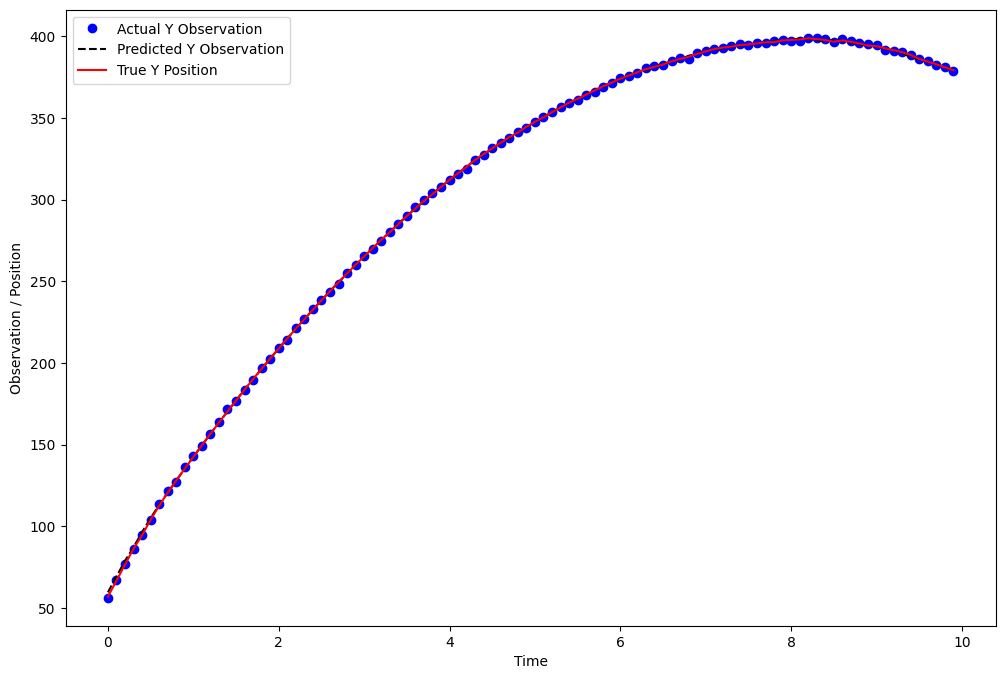

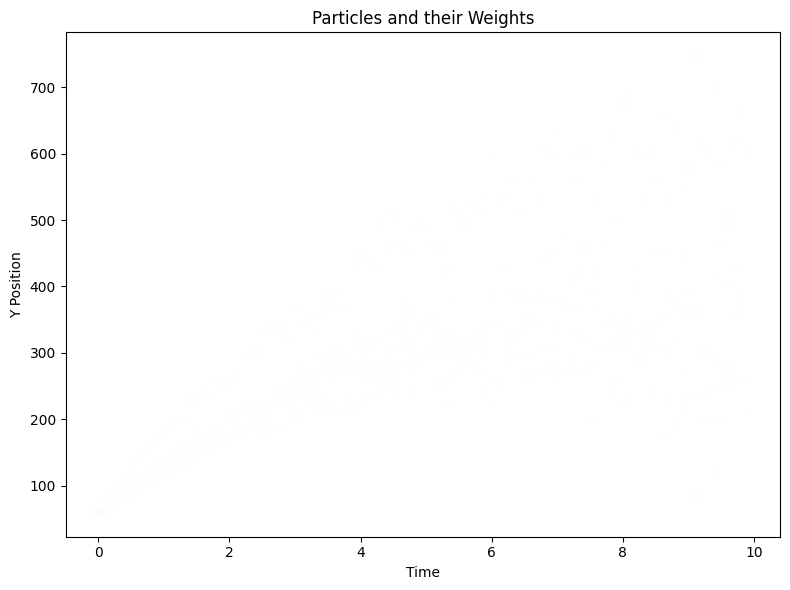

In [41]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
no_particles = 5000
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 0.5
launch_position = [20,50]
launch_speed = 100
launch_angle = 45
start_ob_time = 2
stop_ob_time = 7
skip_observations = False
observations_ball1_1, predicted_observations_ball1_1 = simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle,no_particles= no_particles, total_time=10.0, dt=0.1, observation_time_step=0.5, observation_error_std=Observation_noise, R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,skip_observations = skip_observations)

In [42]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy_particle(observations_ball1_1, predicted_observations_ball1_1)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 0.81
MAE: 0.60



### 3.2.3 Skip_observation = True | no of particles: 5000 | Observation Failure


C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:34: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  self.particles = [np.dot(A, particle) + np.dot(B, a) + np.random.multivariate_normal(np.zeros(particle.shape[0]), self.transition_covariance) for particle in self.particles]


Time: 0.00
Actual Observation: [-42.59106734 -22.29513659]
Predicted Observation: [-44.18182333 -24.49307157]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.37, 70.21)

Time: 0.10
Actual Observation: [-38.16581965 -16.35428258]
Predicted Observation: [-33.9882144  -19.00660011]
Actual Velocity (X, Y): (70.37, 69.23)
Predicted Velocity (X, Y): (71.71, 68.93)

Time: 0.20
Actual Observation: [-22.69572631 -13.3627595 ]
Predicted Observation: [-27.26787202 -12.6131092 ]
Actual Velocity (X, Y): (71.71, 67.95)
Predicted Velocity (X, Y): (71.28, 67.52)

Time: 0.30
Actual Observation: [-17.93946684  -5.17715173]
Predicted Observation: [-20.30909048  -6.07917913]
Actual Velocity (X, Y): (71.28, 66.54)
Predicted Velocity (X, Y): (71.11, 66.37)

Time: 0.40
Actual Observation: [-14.89497978   2.41958699]
Predicted Observation: [-13.43509893   0.27196095]
Actual Velocity (X, Y): (71.11, 65.39)
Predicted Velocity (X, Y): (70.88, 65.16)

Time: 0.50
Actual Observation: [-4.66306

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]
C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:51: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)


Time: 1.40
Actual Observation: [55.31094231 56.3547555 ]
Predicted Observation: [51.93005893 55.01860414]
Actual Velocity (X, Y): (67.23, 51.72)
Predicted Velocity (X, Y): (67.22, 51.71)

Time: 1.50
Actual Observation: [59.07932365 61.5347015 ]
Predicted Observation: [58.67632574 60.16401948]
Actual Velocity (X, Y): (67.22, 50.73)
Predicted Velocity (X, Y): (67.25, 50.75)

Time: 1.60
Actual Observation: [64.40798948 63.8371278 ]
Predicted Observation: [65.4017457  65.19058797]
Actual Velocity (X, Y): (67.25, 49.77)
Predicted Velocity (X, Y): (67.25, 49.77)

Time: 1.70
Actual Observation: [72.80109163 71.93325793]
Predicted Observation: [72.17080215 70.16279295]
Actual Velocity (X, Y): (67.25, 48.79)
Predicted Velocity (X, Y): (67.28, 48.83)

Time: 1.80
Actual Observation: [76.51895404 77.227822  ]
Predicted Observation: [78.89496034 74.99209968]
Actual Velocity (X, Y): (67.28, 47.85)
Predicted Velocity (X, Y): (67.27, 47.84)

Time: 1.90
Actual Observation: [83.05647736 77.79592025]
Pre

Time: 5.70
Actual Observation: [217.52774946 152.47112378]
Predicted Observation: [339.88430542 185.64223751]
Actual Velocity (X, Y): (66.82, 9.16)
Predicted Velocity (X, Y): (66.96, 9.30)

Time: 5.80
Actual Observation: [217.52774946 152.47112378]
Predicted Observation: [346.06210577 186.0051864 ]
Actual Velocity (X, Y): (66.96, 8.32)
Predicted Velocity (X, Y): (66.84, 8.21)

Time: 5.90
Actual Observation: [217.52774946 152.47112378]
Predicted Observation: [352.63676684 186.666996  ]
Actual Velocity (X, Y): (66.84, 7.23)
Predicted Velocity (X, Y): (66.81, 7.19)

Time: 6.00
Actual Observation: [217.52774946 152.47112378]
Predicted Observation: [359.6694222 187.6887999]
Actual Velocity (X, Y): (66.81, 6.21)
Predicted Velocity (X, Y): (66.92, 6.32)

Time: 6.10
Actual Observation: [366.35776615 191.37515211]
Predicted Observation: [366.12297781 188.03350404]
Actual Velocity (X, Y): (66.92, 5.34)
Predicted Velocity (X, Y): (66.79, 5.21)

Time: 6.20
Actual Observation: [370.81536326 189.130

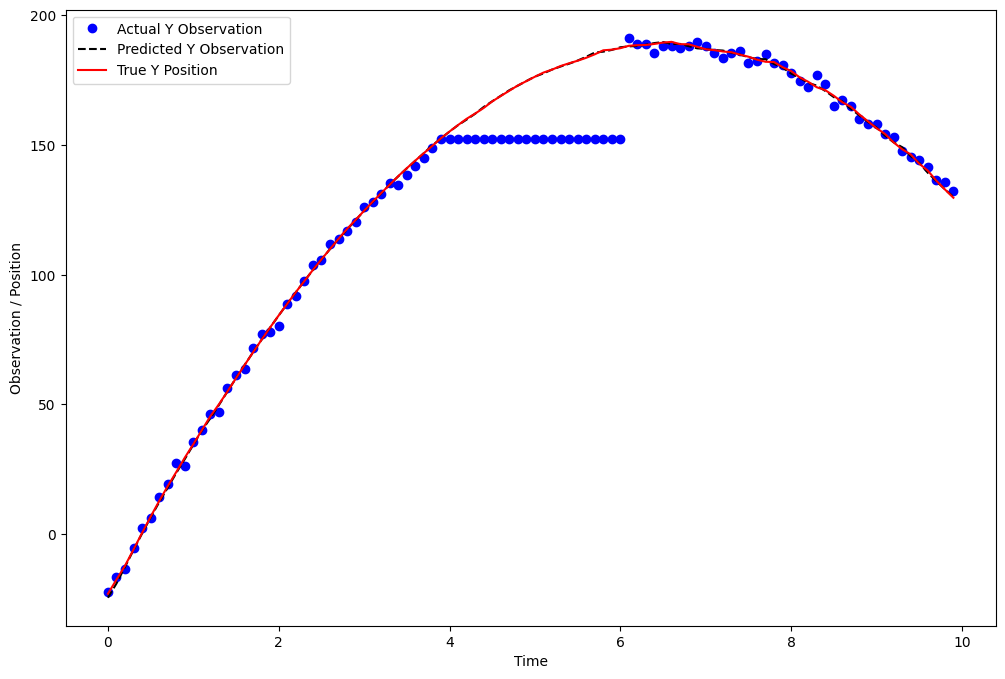

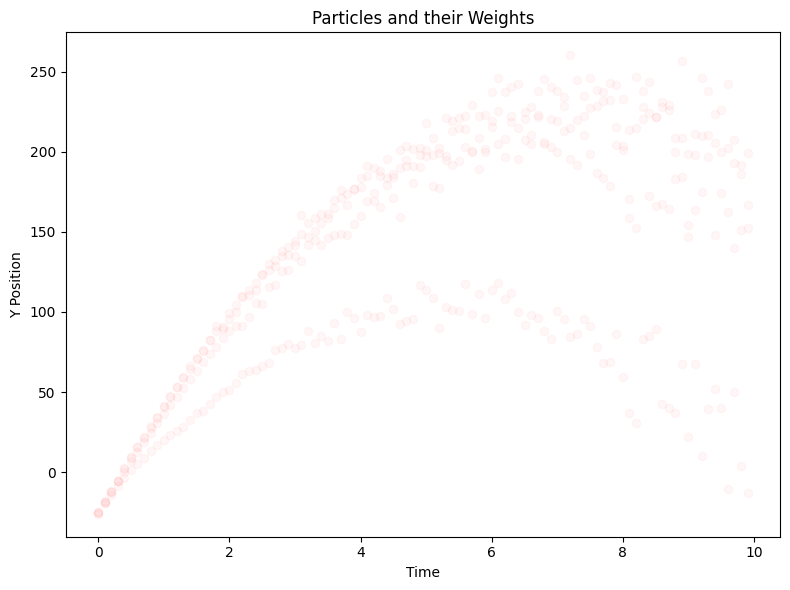

In [43]:
mean_P = 0
sd_P = 1
mean_Q = 0
sd_Q = 1
no_particles = 500
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 2
launch_position = [-50,-30]
launch_speed = 100
launch_angle = 45
start_ob_time = 4
stop_ob_time = 6
skip_observations = True
observations_ball1_1, predicted_observations_ball1_1 = simulate_ball_trajectory_particle(launch_position, launch_speed, launch_angle,no_particles= no_particles, total_time=10.0, dt=0.1, observation_time_step=0.5, observation_error_std=Observation_noise, R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,skip_observations = skip_observations)

In [44]:
# Measure the accuracy of the estimated observations and velocities
obs_rmse, obs_mae = calculate_accuracy_particle(observations_ball1_1, predicted_observations_ball1_1)

# Print the accuracy metrics
print("Observation Loss:")
print(f"RMSE: {obs_rmse:.2f}")
print(f"MAE: {obs_mae:.2f}")
print()

Observation Loss:
RMSE: 11.13
MAE: 5.79



## 3.3 Particle Filter 2 balls 

Time: 0.00
Ball 1:
Actual Observation: [103.52684758 104.02955159]
Predicted Observation: [102.31713127 102.60637173]
Actual Velocity (X, Y): (21.21, 20.23)
Predicted Velocity (X, Y): (21.37, 20.38)

Ball 2:
Actual Observation: [-291.13086573 -298.51639903]
Predicted Observation: [-292.64006298 -294.30075151]
Actual Velocity (X, Y): (70.71, 69.73)
Predicted Velocity (X, Y): (70.37, 69.08)

Time: 0.10
Ball 1:
Actual Observation: [107.9354657  106.79716184]
Predicted Observation: [105.38221839 105.36330591]
Actual Velocity (X, Y): (21.37, 19.40)
Predicted Velocity (X, Y): (22.19, 20.10)

Ball 2:
Actual Observation: [-289.77781605 -283.04457529]
Predicted Observation: [-285.69781206 -286.10838504]
Actual Velocity (X, Y): (70.37, 68.10)
Predicted Velocity (X, Y): (71.03, 69.12)

Time: 0.20
Ball 1:
Actual Observation: [106.60075865 108.13180622]
Predicted Observation: [107.33544135 107.44244032]
Actual Velocity (X, Y): (22.19, 19.12)
Predicted Velocity (X, Y): (22.02, 19.16)

Ball 2:
Actual

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:47: RuntimeWarning: overflow encountered in exp
  self.weights[i] = np.exp(-0.5 * np.dot(np.dot(y.T, np.linalg.inv(self.observation_covariance)), y))[0, 0]


Time: 0.90
Ball 1:
Actual Observation: [121.83153411 112.76425673]
Predicted Observation: [123.03638779 117.26148574]
Actual Velocity (X, Y): (19.49, 8.96)
Predicted Velocity (X, Y): (22.68, 11.68)

Ball 2:
Actual Observation: [-225.78959622 -216.81985113]
Predicted Observation: [-222.01793158 -222.87639509]
Actual Velocity (X, Y): (73.58, 67.15)
Predicted Velocity (X, Y): (75.16, 69.14)

Time: 1.00
Ball 1:
Actual Observation: [127.49348734 116.21139932]
Predicted Observation: [126.777529   119.64302229]
Actual Velocity (X, Y): (22.68, 10.70)
Predicted Velocity (X, Y): (24.29, 11.91)

Ball 2:
Actual Observation: [-217.37999079 -220.03160571]
Predicted Observation: [-216.02377895 -217.53390673]
Actual Velocity (X, Y): (75.16, 68.16)
Predicted Velocity (X, Y): (73.83, 66.82)

Time: 1.10
Ball 1:
Actual Observation: [126.21884078 130.30676634]
Predicted Observation: [126.25916292 119.16794689]
Actual Velocity (X, Y): (24.29, 10.93)
Predicted Velocity (X, Y): (22.57, 10.86)

Ball 2:
Actual 

Time: 3.00
Ball 1:
Actual Observation: [186.44610106 144.96473581]
Predicted Observation: [187.83906028 141.63320437]
Actual Velocity (X, Y): (25.87, -4.00)
Predicted Velocity (X, Y): (29.36, -0.50)

Ball 2:
Actual Observation: [-52.35236051 -87.79183424]
Predicted Observation: [-54.54466204 -89.66807529]
Actual Velocity (X, Y): (78.71, 52.10)
Predicted Velocity (X, Y): (78.10, 51.50)

Time: 3.10
Ball 1:
Actual Observation: [190.34826025 143.30121779]
Predicted Observation: [190.9350132  141.69346637]
Actual Velocity (X, Y): (29.36, -1.48)
Predicted Velocity (X, Y): (29.33, -1.52)

Ball 2:
Actual Observation: [-45.80289427 -83.60579343]
Predicted Observation: [-44.92689096 -82.75996849]
Actual Velocity (X, Y): (78.10, 50.52)
Predicted Velocity (X, Y): (79.11, 51.52)

Time: 3.20
Ball 1:
Actual Observation: [200.48751964 139.10918792]
Predicted Observation: [193.94726827 141.57203052]
Actual Velocity (X, Y): (29.33, -2.50)
Predicted Velocity (X, Y): (29.19, -2.63)

Ball 2:
Actual Observa

Time: 5.10
Ball 1:
Actual Observation: [208.40317077 134.70954074]
Predicted Observation: [243.96153965 113.42617452]
Actual Velocity (X, Y): (26.45, -24.00)
Predicted Velocity (X, Y): (27.01, -23.44)

Ball 2:
Actual Observation: [ 23.3217557  -48.06020759]
Predicted Observation: [106.91964651  -5.68671649]
Actual Velocity (X, Y): (71.39, 24.20)
Predicted Velocity (X, Y): (72.12, 24.93)

Time: 5.20
Ball 1:
Actual Observation: [208.40317077 134.70954074]
Predicted Observation: [248.45373226 112.82467621]
Actual Velocity (X, Y): (27.01, -24.42)
Predicted Velocity (X, Y): (27.74, -23.69)

Ball 2:
Actual Observation: [ 23.3217557  -48.06020759]
Predicted Observation: [117.22522036  -0.14880691]
Actual Velocity (X, Y): (72.12, 23.95)
Predicted Velocity (X, Y): (73.17, 25.00)

Time: 5.30
Ball 1:
Actual Observation: [208.40317077 134.70954074]
Predicted Observation: [250.57415039 109.75340343]
Actual Velocity (X, Y): (27.74, -24.67)
Predicted Velocity (X, Y): (27.34, -25.07)

Ball 2:
Actual O

C:\Users\Mian\AppData\Local\Temp\ipykernel_18364\3483127224.py:51: RuntimeWarning: invalid value encountered in divide
  self.weights /= np.sum(self.weights)


Time: 5.90
Ball 1:
Actual Observation: [208.40317077 134.70954074]
Predicted Observation: [262.84368144  88.81478899]
Actual Velocity (X, Y): (26.76, -31.53)
Predicted Velocity (X, Y): (26.35, -31.94)

Ball 2:
Actual Observation: [ 23.3217557  -48.06020759]
Predicted Observation: [168.45903237  14.96735518]
Actual Velocity (X, Y): (71.31, 16.29)
Predicted Velocity (X, Y): (71.70, 16.68)

Time: 6.00
Ball 1:
Actual Observation: [208.40317077 134.70954074]
Predicted Observation: [263.81652888  83.90994551]
Actual Velocity (X, Y): (26.35, -32.92)
Predicted Velocity (X, Y): (25.94, -33.33)

Ball 2:
Actual Observation: [ 23.3217557  -48.06020759]
Predicted Observation: [176.98463074  17.94128928]
Actual Velocity (X, Y): (71.70, 15.70)
Predicted Velocity (X, Y): (71.87, 15.86)

Time: 6.10
Ball 1:
Actual Observation: [272.95646377  79.19607989]
Predicted Observation: [267.58150006  81.69922578]
Actual Velocity (X, Y): (25.94, -34.31)
Predicted Velocity (X, Y): (27.30, -32.95)

Ball 2:
Actual O

Time: 8.10
Ball 1:
Actual Observation: [ 213.08783286 -113.57166003]
Predicted Observation: [ 213.99125317 -111.98483941]
Actual Velocity (X, Y): (-2.18, -82.03)
Predicted Velocity (X, Y): (-2.20, -82.04)

Ball 2:
Actual Observation: [326.96553226  22.10286451]
Predicted Observation: [332.32243601  34.0561448 ]
Actual Velocity (X, Y): (70.93, -5.65)
Predicted Velocity (X, Y): (70.73, -5.86)

Time: 8.20
Ball 1:
Actual Observation: [ 217.6863617  -120.11539836]
Predicted Observation: [ 207.44778638 -126.56199712]
Actual Velocity (X, Y): (-2.20, -83.02)
Predicted Velocity (X, Y): (-8.34, -89.17)

Ball 2:
Actual Observation: [333.94398957  38.24293972]
Predicted Observation: [339.07447757  33.10052209]
Actual Velocity (X, Y): (70.73, -6.84)
Predicted Velocity (X, Y): (71.04, -6.53)

Time: 8.30
Ball 1:
Actual Observation: [ 205.36580752 -131.29140614]
Predicted Observation: [ 202.59271819 -139.54875623]
Actual Velocity (X, Y): (-8.34, -90.15)
Predicted Velocity (X, Y): (-12.36, -94.17)

Bal

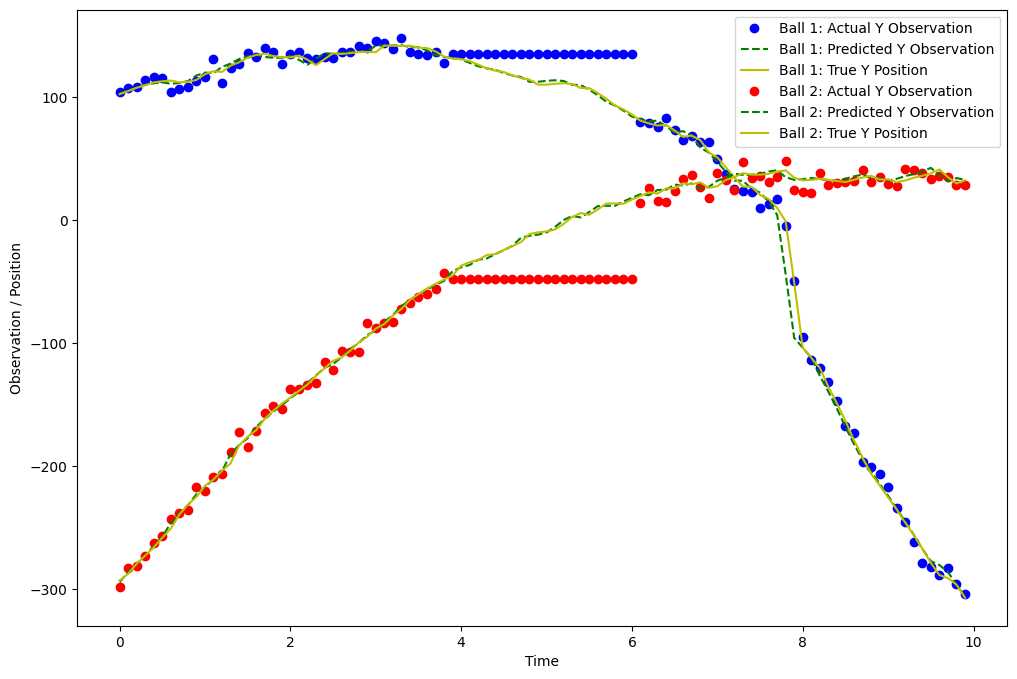

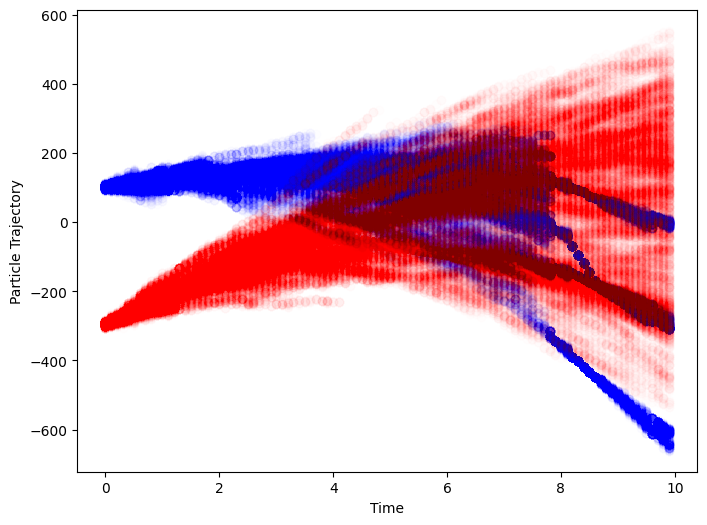

In [45]:
mean_P = 0
sd_P = 10
mean_Q = 0
sd_Q = 10
no_particles = 500
P = np.random.normal(mean_P, sd_P)
Q = np.random.normal(mean_Q, sd_Q)
Observation_noise = 5
launch_position = [100,100]
launch_speed = 30
launch_angle = 45
launch_position2 = [-300, -300]
launch_speed2 = 100
launch_angle2 = 45
start_ob_time = 4
stop_ob_time = 6
skip_observations = True
observations_ball2_1, predicted_observations_ball2_1, observations_ball2_2, predicted_observations_ball2_2 = simulate_ball_trajectory_particle_2balls(launch_position, launch_speed, launch_angle, 
                                                                                                                                      launch_position2, launch_speed2, launch_angle2, 
                                                                                                                                      no_particles= no_particles, total_time=10.0, 
                                                                                                                                      dt=0.1, observation_time_step=0.5, observation_error_std=Observation_noise, 
                                                                                                                                      R_val=P, Q_val=Q, skip_ob_start_time = start_ob_time,skip_ob_stop_time = stop_ob_time,
                                                                                                                                      skip_observations = skip_observations)

In [46]:
# Measure the accuracy of the estimated observations and velocities
rmse1, mae1, rmse2, mae2 = calculate_accuracy_particle_2_balls(observations_ball2_1, predicted_observations_ball2_1, observations_ball2_2, predicted_observations_ball2_2)

# Print the accuracy metrics
print("Observation Loss ball 1:")
print(f"RMSE: {rmse1:.2f}")
print(f"MAE: {mae1:.2f}")
print("Observation Loss ball 2:")
print(f"RMSE: {rmse2:.2f}")
print(f"MAE: {mae2:.2f}")
print()

Observation Loss ball 1:
RMSE: 14.45
MAE: 9.26
Observation Loss ball 2:
RMSE: 20.28
MAE: 11.89

